In [ ]:
# -*- coding : utf-8 -*-

from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras.callbacks import EarlyStopping
from keras import models
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import keras_sub_pack as ksp

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

In [8]:
    class olivetti_CNN(models.Model):

        def __init__(self, conv, nh, pd, in_shape, classes):

            i = Input(shape = in_shape)
            c = Conv2D(conv[0], kernel_size = (3,3), activation='relu')(i)
            for rep in range(1, len(conv)):
                c = Conv2D(conv[rep], kernel_size = (3,3), activation='relu')(c)
                c = MaxPooling2D(pool_size = (2,2))(c)
            c = Dropout(pd[0])(c)
            c = Flatten()(c)

            h = Dense(nh[0], activation='relu')(c)
            h = Dropout(pd[1])(h)

            for rep in range(1, len(nh)):
                h = Dense(nh[rep], activation='relu')(h)
                h = Dropout(pd[rep])(h)
            o = Dense(classes, activation='softmax')(h)

            super().__init__(i, o)
            self.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

In [9]:
    class DATA:

        def __init__(self, rand_stat = 0, test_size = 0.3):

            faces = fetch_olivetti_faces()
            self.in_data, self.out_data = faces.images, faces.target

            self.preprocessing()
            in_data, out_data = self.in_data, self.out_data

            in_train, in_test, out_train, out_test = train_test_split(in_data, out_data, random_state=rand_stat, test_size = test_size)
            self.in_train, self.out_train = in_train, out_train
            self.in_test, self.out_test = in_test, out_test
            self.generator = ImageDataGenerator(rotation_range = 20, width_shift_range=0.05, height_shift_range=0.05)

        def preprocessing(self):

            in_data, out_data = self.in_data, self.out_data
            classes = len(set(out_data))

            length, width, height = in_data.shape
            if K.common.image_dim_ordering() == 'th':
                in_data = in_data.reshape(length, 1, width, height)
                in_shape = (1, width, height)

            else:
                in_data = in_data.reshape(length, width, height, 1)
                in_shape = (width, height, 1)

            out_data = to_categorical(out_data, classes)
            in_data = in_data.astype('float32')

            self.in_data, self.out_data = in_data, out_data
            self.in_shape, self.classes = in_shape, classes

In [10]:
    class main:

        def __init__(self, conv, nh, pd, epo = 15, batch = 20, test_size = 0.3):

            early = EarlyStopping(monitor = 'val_loss', min_delta = 0, mode = 'auto', patience=25)
            data = DATA(test_size = test_size)
            self.model = olivetti_CNN(conv = conv, nh = nh, pd = pd, in_shape = data.in_shape, classes = data.classes)
            # data_flow = data.generator.flow(data.in_train, data.out_train, batch_size=batch)
            #histo = self.model.fit_generator(data_flow, steps_per_epoch=batch, epochs = epo,
            #                                 callbacks=[early], validation_data=(data.in_test, data.out_test))
            histo = self.model.fit(data.in_train,data.out_train, batch_size = batch, epochs = epo,
                                   callbacks=[early], validation_data=(data.in_test, data.out_test))
            loss_n_accu = self.model.evaluate(data.in_test, data.out_test, batch_size=batch)
            print(f'Test loss : {loss_n_accu[0]} \n accuracy : {loss_n_accu[1]}')

            plot = ksp.plot(histo)
            plt.figure(figsize=(12, 5))
            plt.subplot(1,2,1)
            plot.plot_loss()

            plt.subplot(1,2,2)
            plot.plot_acc()
            plt.show()

            pred = self.model.predict(data.in_test, batch_size = batch)
            self.save_n_load()
            self.pred, self.data = pred, data

        def save_n_load(self):

            model = self.model
            suffix = ksp.unique_filename('datatime')

            os.chdir('./weights')
            if not os.path.isdir('olivetti_CNN'):
                os.mkdir('olivetti_CNN')
            os.chdir('olivetti_CNN')

            model.save_weights(suffix + '_kimhippo.h5')
            print('Weights are save in ', os.getcwd())

        def prediction(self, samples):

            pred, data = self.pred, self.data
            for rep in samples:
                pred_ind = np.argmax(pred[rep])
                exac_ind = np.argmax(data.out_test[rep])

                print(f'Predict index : {pred_ind} \n Exact index : {exac_ind}')

Train on 320 samples, validate on 80 samples
Epoch 1/100


 10/320 [..............................] - ETA: 48s - loss: 3.6866 - acc: 0.1000

 30/320 [=>............................] - ETA: 16s - loss: 3.6954 - acc: 0.0333

 50/320 [===>..........................] - ETA: 9s - loss: 3.6935 - acc: 0.0200 

 70/320 [=====>........................] - ETA: 6s - loss: 3.6917 - acc: 0.0571

 90/320 [=======>......................] - ETA: 4s - loss: 3.6982 - acc: 0.0444



110/320 [=========>....................] - ETA: 3s - loss: 3.6946 - acc: 0.0364



130/320 [===========>..................] - ETA: 2s - loss: 3.6957 - acc: 0.0308

150/320 [=============>................] - ETA: 2s - loss: 3.6978 - acc: 0.0267



170/320 [==============>...............] - ETA: 1s - loss: 3.6974 - acc: 0.0235



190/320 [================>.............] - ETA: 1s - loss: 3.6966 - acc: 0.0263



210/320 [==================>...........] - ETA: 1s - loss: 3.6959 - acc: 0.0286

230/320 [====================>.........] - ETA: 0s - loss: 3.6956 - acc: 0.0261



250/320 [======================>.......] - ETA: 0s - loss: 3.6953 - acc: 0.0280



270/320 [========================>.....] - ETA: 0s - loss: 3.6952 - acc: 0.0259

290/320 [==========================>...] - ETA: 0s - loss: 3.6949 - acc: 0.0276



310/320 [============================>.] - ETA: 0s - loss: 3.6946 - acc: 0.0258

320/320 [==============================] - 3s 8ms/step - loss: 3.6946 - acc: 0.0250 - val_loss: 3.6930 - val_acc: 0.0250


Epoch 2/100


 10/320 [..............................] - ETA: 0s - loss: 3.6913 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6887 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6899 - acc: 0.0000e+00



 70/320 [=====>........................] - ETA: 0s - loss: 3.6883 - acc: 0.0143    

 90/320 [=======>......................] - ETA: 0s - loss: 3.6894 - acc: 0.0111

110/320 [=========>....................] - ETA: 0s - loss: 3.6896 - acc: 0.0091

130/320 [===========>..................] - ETA: 0s - loss: 3.6896 - acc: 0.0077

150/320 [=============>................] - ETA: 0s - loss: 3.6895 - acc: 0.0133

170/320 [==============>...............] - ETA: 0s - loss: 3.6894 - acc: 0.0118

190/320 [================>.............] - ETA: 0s - loss: 3.6891 - acc: 0.0211

210/320 [==================>...........] - ETA: 0s - loss: 3.6895 - acc: 0.0190

230/320 [====================>.........] - ETA: 0s - loss: 3.6897 - acc: 0.0217

260/320 [=======================>......] - ETA: 0s - loss: 3.6898 - acc: 0.0192



280/320 [=========================>....] - ETA: 0s - loss: 3.6900 - acc: 0.0179



300/320 [===========================>..] - ETA: 0s - loss: 3.6900 - acc: 0.0167



320/320 [==============================] - 1s 3ms/step - loss: 3.6898 - acc: 0.0188 - val_loss: 3.6962 - val_acc: 0.0000e+00


Epoch 3/100
 10/320 [..............................] - ETA: 0s - loss: 3.6856 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6868 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6873 - acc: 0.0200    

 70/320 [=====>........................] - ETA: 0s - loss: 3.6886 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6881 - acc: 0.0333

110/320 [=========>....................] - ETA: 0s - loss: 3.6881 - acc: 0.0273

130/320 [===========>..................] - ETA: 0s - loss: 3.6881 - acc: 0.0231

150/320 [=============>................] - ETA: 0s - loss: 3.6888 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6880 - acc: 0.0294

190/320 [================>.............] - ETA: 0s - loss: 3.6885 - acc: 0.0316

210/320 [==================>...........] - ETA: 0s - loss: 3.6884 - acc: 0.0286

230/320 [====================>.........] - ETA: 0s - loss: 3.6885 - acc: 0.0261

250/320 [======================>.......] - ETA: 0s - loss: 3.6884 - acc: 0.0240

270/320 [========================>.....] - ETA: 0s - loss: 3.6888 - acc: 0.0222

290/320 [==========================>...] - ETA: 0s - loss: 3.6890 - acc: 0.0207

310/320 [============================>.] - ETA: 0s - loss: 3.6887 - acc: 0.0226

320/320 [==============================] - 1s 3ms/step - loss: 3.6887 - acc: 0.0250 - val_loss: 3.6994 - val_acc: 0.0000e+00


Epoch 4/100
 10/320 [..............................] - ETA: 0s - loss: 3.6787 - acc: 0.1000



 30/320 [=>............................] - ETA: 0s - loss: 3.6837 - acc: 0.1000

 50/320 [===>..........................] - ETA: 0s - loss: 3.6832 - acc: 0.0600

 70/320 [=====>........................] - ETA: 0s - loss: 3.6860 - acc: 0.0429

 90/320 [=======>......................] - ETA: 0s - loss: 3.6866 - acc: 0.0444

110/320 [=========>....................] - ETA: 0s - loss: 3.6862 - acc: 0.0545

130/320 [===========>..................] - ETA: 0s - loss: 3.6873 - acc: 0.0462

150/320 [=============>................] - ETA: 0s - loss: 3.6870 - acc: 0.0467

180/320 [===============>..............] - ETA: 0s - loss: 3.6881 - acc: 0.0444



200/320 [=================>............] - ETA: 0s - loss: 3.6877 - acc: 0.0400

220/320 [===================>..........] - ETA: 0s - loss: 3.6880 - acc: 0.0409

240/320 [=====================>........] - ETA: 0s - loss: 3.6881 - acc: 0.0375

260/320 [=======================>......] - ETA: 0s - loss: 3.6881 - acc: 0.0385

290/320 [==========================>...] - ETA: 0s - loss: 3.6883 - acc: 0.0379

310/320 [============================>.] - ETA: 0s - loss: 3.6879 - acc: 0.0387

320/320 [==============================] - 1s 3ms/step - loss: 3.6877 - acc: 0.0375 - val_loss: 3.7028 - val_acc: 0.0000e+00


Epoch 5/100


 10/320 [..............................] - ETA: 1s - loss: 3.6847 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6801 - acc: 0.0667    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6878 - acc: 0.0400

 70/320 [=====>........................] - ETA: 0s - loss: 3.6897 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6901 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6916 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6917 - acc: 0.0154

150/320 [=============>................] - ETA: 0s - loss: 3.6906 - acc: 0.0133

170/320 [==============>...............] - ETA: 0s - loss: 3.6904 - acc: 0.0176

190/320 [================>.............] - ETA: 0s - loss: 3.6899 - acc: 0.0158

210/320 [==================>...........] - ETA: 0s - loss: 3.6896 - acc: 0.0143

230/320 [====================>.........] - ETA: 0s - loss: 3.6898 - acc: 0.0130

250/320 [======================>.......] - ETA: 0s - loss: 3.6891 - acc: 0.0120

270/320 [========================>.....] - ETA: 0s - loss: 3.6886 - acc: 0.0148

290/320 [==========================>...] - ETA: 0s - loss: 3.6885 - acc: 0.0172

310/320 [============================>.] - ETA: 0s - loss: 3.6883 - acc: 0.0161

320/320 [==============================] - 1s 3ms/step - loss: 3.6880 - acc: 0.0156 - val_loss: 3.7069 - val_acc: 0.0125


Epoch 6/100
 10/320 [..............................] - ETA: 0s - loss: 3.6827 - acc: 0.1000

 30/320 [=>............................] - ETA: 0s - loss: 3.6891 - acc: 0.0333

 50/320 [===>..........................] - ETA: 0s - loss: 3.6877 - acc: 0.0200

 80/320 [======>.......................] - ETA: 0s - loss: 3.6870 - acc: 0.0500



100/320 [========>.....................] - ETA: 0s - loss: 3.6882 - acc: 0.0400

120/320 [==========>...................] - ETA: 0s - loss: 3.6863 - acc: 0.0583

140/320 [============>.................] - ETA: 0s - loss: 3.6869 - acc: 0.0500

160/320 [==============>...............] - ETA: 0s - loss: 3.6863 - acc: 0.0438

180/320 [===============>..............] - ETA: 0s - loss: 3.6863 - acc: 0.0389

200/320 [=================>............] - ETA: 0s - loss: 3.6866 - acc: 0.0350

220/320 [===================>..........] - ETA: 0s - loss: 3.6869 - acc: 0.0318

240/320 [=====================>........] - ETA: 0s - loss: 3.6872 - acc: 0.0333

260/320 [=======================>......] - ETA: 0s - loss: 3.6871 - acc: 0.0308

280/320 [=========================>....] - ETA: 0s - loss: 3.6870 - acc: 0.0286

300/320 [===========================>..] - ETA: 0s - loss: 3.6866 - acc: 0.0267

320/320 [==============================] - 1s 3ms/step - loss: 3.6866 - acc: 0.0281 - val_loss: 3.7097 - val_acc: 0.0000e+00


Epoch 7/100


 10/320 [..............................] - ETA: 0s - loss: 3.6809 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6822 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6835 - acc: 0.0000e+00

 70/320 [=====>........................] - ETA: 0s - loss: 3.6799 - acc: 0.0429    

 90/320 [=======>......................] - ETA: 0s - loss: 3.6802 - acc: 0.0444



110/320 [=========>....................] - ETA: 0s - loss: 3.6789 - acc: 0.0364



130/320 [===========>..................] - ETA: 0s - loss: 3.6799 - acc: 0.0385

150/320 [=============>................] - ETA: 0s - loss: 3.6835 - acc: 0.0333

170/320 [==============>...............] - ETA: 0s - loss: 3.6820 - acc: 0.0412

190/320 [================>.............] - ETA: 0s - loss: 3.6824 - acc: 0.0368

210/320 [==================>...........] - ETA: 0s - loss: 3.6843 - acc: 0.0333

230/320 [====================>.........] - ETA: 0s - loss: 3.6850 - acc: 0.0304

250/320 [======================>.......] - ETA: 0s - loss: 3.6854 - acc: 0.0280

270/320 [========================>.....] - ETA: 0s - loss: 3.6851 - acc: 0.0296

290/320 [==========================>...] - ETA: 0s - loss: 3.6854 - acc: 0.0276

310/320 [============================>.] - ETA: 0s - loss: 3.6868 - acc: 0.0258

320/320 [==============================] - 1s 3ms/step - loss: 3.6864 - acc: 0.0250 - val_loss: 3.7115 - val_acc: 0.0000e+00


Epoch 8/100
 10/320 [..............................] - ETA: 0s - loss: 3.6879 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6921 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6936 - acc: 0.0200

 80/320 [======>.......................] - ETA: 0s - loss: 3.6932 - acc: 0.0125



100/320 [========>.....................] - ETA: 0s - loss: 3.6905 - acc: 0.0100



120/320 [==========>...................] - ETA: 0s - loss: 3.6879 - acc: 0.0083

140/320 [============>.................] - ETA: 0s - loss: 3.6861 - acc: 0.0143

160/320 [==============>...............] - ETA: 0s - loss: 3.6866 - acc: 0.0188

180/320 [===============>..............] - ETA: 0s - loss: 3.6872 - acc: 0.0222

200/320 [=================>............] - ETA: 0s - loss: 3.6883 - acc: 0.0200

220/320 [===================>..........] - ETA: 0s - loss: 3.6876 - acc: 0.0227

240/320 [=====================>........] - ETA: 0s - loss: 3.6875 - acc: 0.0208

260/320 [=======================>......] - ETA: 0s - loss: 3.6867 - acc: 0.0231

280/320 [=========================>....] - ETA: 0s - loss: 3.6860 - acc: 0.0214

300/320 [===========================>..] - ETA: 0s - loss: 3.6854 - acc: 0.0233

320/320 [==============================] - 1s 3ms/step - loss: 3.6856 - acc: 0.0219 - val_loss: 3.7150 - val_acc: 0.0000e+00


Epoch 9/100
 10/320 [..............................] - ETA: 0s - loss: 3.6807 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6856 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6872 - acc: 0.0200    

 70/320 [=====>........................] - ETA: 0s - loss: 3.6837 - acc: 0.0143

100/320 [========>.....................] - ETA: 0s - loss: 3.6871 - acc: 0.0200



120/320 [==========>...................] - ETA: 0s - loss: 3.6870 - acc: 0.0250

140/320 [============>.................] - ETA: 0s - loss: 3.6884 - acc: 0.0286

160/320 [==============>...............] - ETA: 0s - loss: 3.6876 - acc: 0.0250

180/320 [===============>..............] - ETA: 0s - loss: 3.6865 - acc: 0.0222

210/320 [==================>...........] - ETA: 0s - loss: 3.6862 - acc: 0.0190

230/320 [====================>.........] - ETA: 0s - loss: 3.6854 - acc: 0.0174

250/320 [======================>.......] - ETA: 0s - loss: 3.6853 - acc: 0.0200

270/320 [========================>.....] - ETA: 0s - loss: 3.6854 - acc: 0.0259

290/320 [==========================>...] - ETA: 0s - loss: 3.6845 - acc: 0.0241

310/320 [============================>.] - ETA: 0s - loss: 3.6842 - acc: 0.0226

320/320 [==============================] - 1s 3ms/step - loss: 3.6844 - acc: 0.0219 - val_loss: 3.7202 - val_acc: 0.0125


Epoch 10/100
 10/320 [..............................] - ETA: 1s - loss: 3.6794 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6810 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6759 - acc: 0.0200

 70/320 [=====>........................] - ETA: 0s - loss: 3.7094 - acc: 0.0143

 90/320 [=======>......................] - ETA: 0s - loss: 3.7050 - acc: 0.0111

110/320 [=========>....................] - ETA: 0s - loss: 3.7004 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6974 - acc: 0.0308

150/320 [=============>................] - ETA: 0s - loss: 3.6950 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6943 - acc: 0.0235

190/320 [================>.............] - ETA: 0s - loss: 3.6950 - acc: 0.0211

210/320 [==================>...........] - ETA: 0s - loss: 3.6926 - acc: 0.0238

230/320 [====================>.........] - ETA: 0s - loss: 3.6924 - acc: 0.0217

250/320 [======================>.......] - ETA: 0s - loss: 3.6904 - acc: 0.0200

270/320 [========================>.....] - ETA: 0s - loss: 3.6912 - acc: 0.0185

290/320 [==========================>...] - ETA: 0s - loss: 3.6901 - acc: 0.0172

310/320 [============================>.] - ETA: 0s - loss: 3.6902 - acc: 0.0161

320/320 [==============================] - 1s 3ms/step - loss: 3.6900 - acc: 0.0156 - val_loss: 3.7221 - val_acc: 0.0125


Epoch 11/100
 10/320 [..............................] - ETA: 0s - loss: 3.6775 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6694 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6820 - acc: 0.0200    



 70/320 [=====>........................] - ETA: 0s - loss: 3.6842 - acc: 0.0143

 90/320 [=======>......................] - ETA: 0s - loss: 3.6844 - acc: 0.0111

110/320 [=========>....................] - ETA: 0s - loss: 3.6869 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6868 - acc: 0.0154

150/320 [=============>................] - ETA: 0s - loss: 3.6873 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6873 - acc: 0.0294

190/320 [================>.............] - ETA: 0s - loss: 3.6870 - acc: 0.0316

210/320 [==================>...........] - ETA: 0s - loss: 3.6852 - acc: 0.0429

230/320 [====================>.........] - ETA: 0s - loss: 3.6847 - acc: 0.0391

250/320 [======================>.......] - ETA: 0s - loss: 3.6839 - acc: 0.0400

270/320 [========================>.....] - ETA: 0s - loss: 3.6837 - acc: 0.0370

290/320 [==========================>...] - ETA: 0s - loss: 3.6828 - acc: 0.0345

310/320 [============================>.] - ETA: 0s - loss: 3.6834 - acc: 0.0323

320/320 [==============================] - 1s 3ms/step - loss: 3.6836 - acc: 0.0313 - val_loss: 3.7273 - val_acc: 0.0125


Epoch 12/100


 10/320 [..............................] - ETA: 0s - loss: 3.6839 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6694 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6816 - acc: 0.0400

 70/320 [=====>........................] - ETA: 0s - loss: 3.6888 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6892 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6859 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6827 - acc: 0.0231

150/320 [=============>................] - ETA: 0s - loss: 3.6793 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6846 - acc: 0.0235

190/320 [================>.............] - ETA: 0s - loss: 3.6888 - acc: 0.0211

210/320 [==================>...........] - ETA: 0s - loss: 3.6891 - acc: 0.0190

230/320 [====================>.........] - ETA: 0s - loss: 3.6882 - acc: 0.0174

250/320 [======================>.......] - ETA: 0s - loss: 3.6885 - acc: 0.0160

270/320 [========================>.....] - ETA: 0s - loss: 3.6874 - acc: 0.0148

290/320 [==========================>...] - ETA: 0s - loss: 3.6873 - acc: 0.0207

310/320 [============================>.] - ETA: 0s - loss: 3.6866 - acc: 0.0226



320/320 [==============================] - 1s 3ms/step - loss: 3.6867 - acc: 0.0250 - val_loss: 3.7262 - val_acc: 0.0000e+00


Epoch 13/100


 10/320 [..............................] - ETA: 0s - loss: 3.6598 - acc: 0.3000



 30/320 [=>............................] - ETA: 0s - loss: 3.6772 - acc: 0.1000

 50/320 [===>..........................] - ETA: 0s - loss: 3.6715 - acc: 0.1200



 70/320 [=====>........................] - ETA: 0s - loss: 3.6810 - acc: 0.0857



 90/320 [=======>......................] - ETA: 0s - loss: 3.6822 - acc: 0.0667

110/320 [=========>....................] - ETA: 0s - loss: 3.6831 - acc: 0.0545

130/320 [===========>..................] - ETA: 0s - loss: 3.6869 - acc: 0.0538

150/320 [=============>................] - ETA: 0s - loss: 3.6827 - acc: 0.0600

170/320 [==============>...............] - ETA: 0s - loss: 3.6824 - acc: 0.0588

190/320 [================>.............] - ETA: 0s - loss: 3.6809 - acc: 0.0579

210/320 [==================>...........] - ETA: 0s - loss: 3.6817 - acc: 0.0524

230/320 [====================>.........] - ETA: 0s - loss: 3.6833 - acc: 0.0522

250/320 [======================>.......] - ETA: 0s - loss: 3.6821 - acc: 0.0480

270/320 [========================>.....] - ETA: 0s - loss: 3.6818 - acc: 0.0481

290/320 [==========================>...] - ETA: 0s - loss: 3.6823 - acc: 0.0448

310/320 [============================>.] - ETA: 0s - loss: 3.6829 - acc: 0.0419

320/320 [==============================] - 1s 3ms/step - loss: 3.6834 - acc: 0.0406 - val_loss: 3.7282 - val_acc: 0.0125


Epoch 14/100
 10/320 [..............................] - ETA: 0s - loss: 3.6947 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6922 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6729 - acc: 0.0600



 70/320 [=====>........................] - ETA: 0s - loss: 3.6724 - acc: 0.0429

 90/320 [=======>......................] - ETA: 0s - loss: 3.6755 - acc: 0.0333

110/320 [=========>....................] - ETA: 0s - loss: 3.6764 - acc: 0.0364

130/320 [===========>..................] - ETA: 0s - loss: 3.6796 - acc: 0.0308

150/320 [=============>................] - ETA: 0s - loss: 3.6821 - acc: 0.0400

170/320 [==============>...............] - ETA: 0s - loss: 3.6808 - acc: 0.0412

190/320 [================>.............] - ETA: 0s - loss: 3.6808 - acc: 0.0368

210/320 [==================>...........] - ETA: 0s - loss: 3.6831 - acc: 0.0333

230/320 [====================>.........] - ETA: 0s - loss: 3.6830 - acc: 0.0304

250/320 [======================>.......] - ETA: 0s - loss: 3.6831 - acc: 0.0360

270/320 [========================>.....] - ETA: 0s - loss: 3.6848 - acc: 0.0333

290/320 [==========================>...] - ETA: 0s - loss: 3.6838 - acc: 0.0310

310/320 [============================>.] - ETA: 0s - loss: 3.6842 - acc: 0.0290

320/320 [==============================] - 1s 3ms/step - loss: 3.6839 - acc: 0.0281 - val_loss: 3.7320 - val_acc: 0.0125


Epoch 15/100
 10/320 [..............................] - ETA: 0s - loss: 3.7007 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6864 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6846 - acc: 0.0200    



 70/320 [=====>........................] - ETA: 0s - loss: 3.6796 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6860 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6846 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6862 - acc: 0.0231

150/320 [=============>................] - ETA: 0s - loss: 3.6859 - acc: 0.0200

170/320 [==============>...............] - ETA: 0s - loss: 3.6865 - acc: 0.0176

190/320 [================>.............] - ETA: 0s - loss: 3.6851 - acc: 0.0211

210/320 [==================>...........] - ETA: 0s - loss: 3.6845 - acc: 0.0238

230/320 [====================>.........] - ETA: 0s - loss: 3.6847 - acc: 0.0217

250/320 [======================>.......] - ETA: 0s - loss: 3.6831 - acc: 0.0240

270/320 [========================>.....] - ETA: 0s - loss: 3.6829 - acc: 0.0222

290/320 [==========================>...] - ETA: 0s - loss: 3.6831 - acc: 0.0207



310/320 [============================>.] - ETA: 0s - loss: 3.6821 - acc: 0.0226



320/320 [==============================] - 1s 3ms/step - loss: 3.6813 - acc: 0.0219 - val_loss: 3.7404 - val_acc: 0.0125


Epoch 16/100
 10/320 [..............................] - ETA: 1s - loss: 3.6862 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 1s - loss: 3.6970 - acc: 0.0000e+00



 50/320 [===>..........................] - ETA: 0s - loss: 3.6833 - acc: 0.0000e+00

 70/320 [=====>........................] - ETA: 0s - loss: 3.6786 - acc: 0.0429    

 90/320 [=======>......................] - ETA: 0s - loss: 3.6811 - acc: 0.0333

110/320 [=========>....................] - ETA: 0s - loss: 3.6850 - acc: 0.0273

130/320 [===========>..................] - ETA: 0s - loss: 3.6846 - acc: 0.0385

150/320 [=============>................] - ETA: 0s - loss: 3.6810 - acc: 0.0400

170/320 [==============>...............] - ETA: 0s - loss: 3.6814 - acc: 0.0353

190/320 [================>.............] - ETA: 0s - loss: 3.6803 - acc: 0.0368

210/320 [==================>...........] - ETA: 0s - loss: 3.6815 - acc: 0.0333

230/320 [====================>.........] - ETA: 0s - loss: 3.6836 - acc: 0.0391

250/320 [======================>.......] - ETA: 0s - loss: 3.6836 - acc: 0.0360

270/320 [========================>.....] - ETA: 0s - loss: 3.6843 - acc: 0.0333

290/320 [==========================>...] - ETA: 0s - loss: 3.6828 - acc: 0.0345

310/320 [============================>.] - ETA: 0s - loss: 3.6833 - acc: 0.0355

320/320 [==============================] - 1s 3ms/step - loss: 3.6834 - acc: 0.0344 - val_loss: 3.7400 - val_acc: 0.0125


Epoch 17/100
 10/320 [..............................] - ETA: 0s - loss: 3.6705 - acc: 0.1000

 30/320 [=>............................] - ETA: 0s - loss: 3.6637 - acc: 0.1000

 50/320 [===>..........................] - ETA: 0s - loss: 3.6749 - acc: 0.0800



 70/320 [=====>........................] - ETA: 0s - loss: 3.6778 - acc: 0.0714

 90/320 [=======>......................] - ETA: 0s - loss: 3.6774 - acc: 0.0556

110/320 [=========>....................] - ETA: 0s - loss: 3.6761 - acc: 0.0455

130/320 [===========>..................] - ETA: 0s - loss: 3.6726 - acc: 0.0462

150/320 [=============>................] - ETA: 0s - loss: 3.6699 - acc: 0.0400

170/320 [==============>...............] - ETA: 0s - loss: 3.6784 - acc: 0.0353

190/320 [================>.............] - ETA: 0s - loss: 3.6781 - acc: 0.0421

210/320 [==================>...........] - ETA: 0s - loss: 3.6785 - acc: 0.0381

230/320 [====================>.........] - ETA: 0s - loss: 3.6793 - acc: 0.0348

250/320 [======================>.......] - ETA: 0s - loss: 3.6799 - acc: 0.0320

270/320 [========================>.....] - ETA: 0s - loss: 3.6798 - acc: 0.0296

290/320 [==========================>...] - ETA: 0s - loss: 3.6806 - acc: 0.0276

310/320 [============================>.] - ETA: 0s - loss: 3.6811 - acc: 0.0290

320/320 [==============================] - 1s 3ms/step - loss: 3.6819 - acc: 0.0281 - val_loss: 3.7350 - val_acc: 0.0000e+00


Epoch 18/100


 10/320 [..............................] - ETA: 0s - loss: 3.6620 - acc: 0.2000

 30/320 [=>............................] - ETA: 0s - loss: 3.6867 - acc: 0.0667

 50/320 [===>..........................] - ETA: 0s - loss: 3.6891 - acc: 0.0400



 70/320 [=====>........................] - ETA: 0s - loss: 3.6876 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6881 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6899 - acc: 0.0273

130/320 [===========>..................] - ETA: 0s - loss: 3.6853 - acc: 0.0308

150/320 [=============>................] - ETA: 0s - loss: 3.6854 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6826 - acc: 0.0235

190/320 [================>.............] - ETA: 0s - loss: 3.6820 - acc: 0.0211

210/320 [==================>...........] - ETA: 0s - loss: 3.6816 - acc: 0.0190

230/320 [====================>.........] - ETA: 0s - loss: 3.6800 - acc: 0.0217

250/320 [======================>.......] - ETA: 0s - loss: 3.6813 - acc: 0.0200

270/320 [========================>.....] - ETA: 0s - loss: 3.6801 - acc: 0.0222

290/320 [==========================>...] - ETA: 0s - loss: 3.6814 - acc: 0.0207

310/320 [============================>.] - ETA: 0s - loss: 3.6829 - acc: 0.0194



320/320 [==============================] - 1s 3ms/step - loss: 3.6819 - acc: 0.0219 - val_loss: 3.7396 - val_acc: 0.0000e+00


Epoch 19/100
 10/320 [..............................] - ETA: 0s - loss: 3.6921 - acc: 0.2000

 30/320 [=>............................] - ETA: 0s - loss: 3.6680 - acc: 0.1000

 50/320 [===>..........................] - ETA: 0s - loss: 3.6762 - acc: 0.0600



 70/320 [=====>........................] - ETA: 0s - loss: 3.6738 - acc: 0.0714

 90/320 [=======>......................] - ETA: 0s - loss: 3.6693 - acc: 0.0778

110/320 [=========>....................] - ETA: 0s - loss: 3.6751 - acc: 0.0727

130/320 [===========>..................] - ETA: 0s - loss: 3.6750 - acc: 0.0923

150/320 [=============>................] - ETA: 0s - loss: 3.6586 - acc: 0.0933

170/320 [==============>...............] - ETA: 0s - loss: 3.6595 - acc: 0.0824

190/320 [================>.............] - ETA: 0s - loss: 3.6640 - acc: 0.0737

210/320 [==================>...........] - ETA: 0s - loss: 3.6639 - acc: 0.0667

230/320 [====================>.........] - ETA: 0s - loss: 3.6652 - acc: 0.0609

250/320 [======================>.......] - ETA: 0s - loss: 3.6671 - acc: 0.0560

270/320 [========================>.....] - ETA: 0s - loss: 3.6678 - acc: 0.0519

290/320 [==========================>...] - ETA: 0s - loss: 3.6670 - acc: 0.0517

310/320 [============================>.] - ETA: 0s - loss: 3.6677 - acc: 0.0516



320/320 [==============================] - 1s 3ms/step - loss: 3.6700 - acc: 0.0500 - val_loss: 3.7454 - val_acc: 0.0000e+00


Epoch 20/100
 10/320 [..............................] - ETA: 0s - loss: 3.6663 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6752 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6638 - acc: 0.0200



 70/320 [=====>........................] - ETA: 0s - loss: 3.6745 - acc: 0.0143

 90/320 [=======>......................] - ETA: 0s - loss: 3.6780 - acc: 0.0111

110/320 [=========>....................] - ETA: 0s - loss: 3.6800 - acc: 0.0182

130/320 [===========>..................] - ETA: 0s - loss: 3.6838 - acc: 0.0231

150/320 [=============>................] - ETA: 0s - loss: 3.6836 - acc: 0.0267

170/320 [==============>...............] - ETA: 0s - loss: 3.6818 - acc: 0.0235

190/320 [================>.............] - ETA: 0s - loss: 3.6709 - acc: 0.0316

210/320 [==================>...........] - ETA: 0s - loss: 3.6710 - acc: 0.0333

230/320 [====================>.........] - ETA: 0s - loss: 3.6704 - acc: 0.0391

250/320 [======================>.......] - ETA: 0s - loss: 3.6748 - acc: 0.0360

270/320 [========================>.....] - ETA: 0s - loss: 3.6740 - acc: 0.0370

290/320 [==========================>...] - ETA: 0s - loss: 3.6778 - acc: 0.0345

310/320 [============================>.] - ETA: 0s - loss: 3.6769 - acc: 0.0323

320/320 [==============================] - 1s 3ms/step - loss: 3.6774 - acc: 0.0313 - val_loss: 3.7449 - val_acc: 0.0000e+00


Epoch 21/100
 10/320 [..............................] - ETA: 0s - loss: 3.6623 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6668 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6657 - acc: 0.0200

 70/320 [=====>........................] - ETA: 0s - loss: 3.6702 - acc: 0.0143

 90/320 [=======>......................] - ETA: 0s - loss: 3.6703 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6730 - acc: 0.0273

130/320 [===========>..................] - ETA: 0s - loss: 3.6645 - acc: 0.0308

150/320 [=============>................] - ETA: 0s - loss: 3.6728 - acc: 0.0400

170/320 [==============>...............] - ETA: 0s - loss: 3.6689 - acc: 0.0412

190/320 [================>.............] - ETA: 0s - loss: 3.6686 - acc: 0.0368

210/320 [==================>...........] - ETA: 0s - loss: 3.6730 - acc: 0.0381

230/320 [====================>.........] - ETA: 0s - loss: 3.6727 - acc: 0.0435

250/320 [======================>.......] - ETA: 0s - loss: 3.6733 - acc: 0.0440



270/320 [========================>.....] - ETA: 0s - loss: 3.6718 - acc: 0.0481



290/320 [==========================>...] - ETA: 0s - loss: 3.6733 - acc: 0.0448

310/320 [============================>.] - ETA: 0s - loss: 3.6706 - acc: 0.0452

320/320 [==============================] - 1s 3ms/step - loss: 3.6733 - acc: 0.0438 - val_loss: 3.7390 - val_acc: 0.0125


Epoch 22/100


 10/320 [..............................] - ETA: 0s - loss: 3.6748 - acc: 0.0000e+00



 30/320 [=>............................] - ETA: 0s - loss: 3.6510 - acc: 0.0667    

 50/320 [===>..........................] - ETA: 0s - loss: 3.6549 - acc: 0.1000

 70/320 [=====>........................] - ETA: 0s - loss: 3.6623 - acc: 0.0714

 90/320 [=======>......................] - ETA: 0s - loss: 3.6450 - acc: 0.0667

110/320 [=========>....................] - ETA: 0s - loss: 3.6673 - acc: 0.0727

130/320 [===========>..................] - ETA: 0s - loss: 3.6650 - acc: 0.0769

150/320 [=============>................] - ETA: 0s - loss: 3.6595 - acc: 0.0733

170/320 [==============>...............] - ETA: 0s - loss: 3.6538 - acc: 0.0765

190/320 [================>.............] - ETA: 0s - loss: 3.6483 - acc: 0.0684

210/320 [==================>...........] - ETA: 0s - loss: 3.6712 - acc: 0.0619

230/320 [====================>.........] - ETA: 0s - loss: 3.6691 - acc: 0.0609

250/320 [======================>.......] - ETA: 0s - loss: 3.6692 - acc: 0.0600

270/320 [========================>.....] - ETA: 0s - loss: 3.6677 - acc: 0.0630

290/320 [==========================>...] - ETA: 0s - loss: 3.6644 - acc: 0.0621

310/320 [============================>.] - ETA: 0s - loss: 3.6612 - acc: 0.0581

320/320 [==============================] - 1s 3ms/step - loss: 3.6617 - acc: 0.0563 - val_loss: 3.7349 - val_acc: 0.0375


Epoch 23/100
 10/320 [..............................] - ETA: 0s - loss: 3.6680 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.6796 - acc: 0.0000e+00

 50/320 [===>..........................] - ETA: 0s - loss: 3.6584 - acc: 0.0200    



 70/320 [=====>........................] - ETA: 0s - loss: 3.6462 - acc: 0.0286

 90/320 [=======>......................] - ETA: 0s - loss: 3.6515 - acc: 0.0222

110/320 [=========>....................] - ETA: 0s - loss: 3.6541 - acc: 0.0273

130/320 [===========>..................] - ETA: 0s - loss: 3.6410 - acc: 0.0462

150/320 [=============>................] - ETA: 0s - loss: 3.6297 - acc: 0.0667

170/320 [==============>...............] - ETA: 0s - loss: 3.6199 - acc: 0.0765

190/320 [================>.............] - ETA: 0s - loss: 3.6087 - acc: 0.0737

210/320 [==================>...........] - ETA: 0s - loss: 3.6152 - acc: 0.0714

230/320 [====================>.........] - ETA: 0s - loss: 3.6123 - acc: 0.0652

250/320 [======================>.......] - ETA: 0s - loss: 3.6063 - acc: 0.0600

270/320 [========================>.....] - ETA: 0s - loss: 3.6102 - acc: 0.0593

290/320 [==========================>...] - ETA: 0s - loss: 3.6125 - acc: 0.0552

310/320 [============================>.] - ETA: 0s - loss: 3.6166 - acc: 0.0581

320/320 [==============================] - 1s 3ms/step - loss: 3.6195 - acc: 0.0594 - val_loss: 3.7105 - val_acc: 0.0500


Epoch 24/100
 10/320 [..............................] - ETA: 0s - loss: 3.5842 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 3.5483 - acc: 0.0333    

 50/320 [===>..........................] - ETA: 0s - loss: 3.5630 - acc: 0.0200



 70/320 [=====>........................] - ETA: 0s - loss: 3.6504 - acc: 0.0143

 90/320 [=======>......................] - ETA: 0s - loss: 3.6274 - acc: 0.0333

110/320 [=========>....................] - ETA: 0s - loss: 3.5999 - acc: 0.0364

130/320 [===========>..................] - ETA: 0s - loss: 3.5796 - acc: 0.0462

150/320 [=============>................] - ETA: 0s - loss: 3.5555 - acc: 0.0667

170/320 [==============>...............] - ETA: 0s - loss: 3.6148 - acc: 0.0588

190/320 [================>.............] - ETA: 0s - loss: 3.6232 - acc: 0.0526

210/320 [==================>...........] - ETA: 0s - loss: 3.6123 - acc: 0.0524

230/320 [====================>.........] - ETA: 0s - loss: 3.6135 - acc: 0.0522

250/320 [======================>.......] - ETA: 0s - loss: 3.6126 - acc: 0.0520

270/320 [========================>.....] - ETA: 0s - loss: 3.5994 - acc: 0.0556

290/320 [==========================>...] - ETA: 0s - loss: 3.6054 - acc: 0.0517

310/320 [============================>.] - ETA: 0s - loss: 3.5961 - acc: 0.0548



320/320 [==============================] - 1s 3ms/step - loss: 3.5951 - acc: 0.0531 - val_loss: 3.6500 - val_acc: 0.0500


Epoch 25/100


 10/320 [..............................] - ETA: 0s - loss: 3.1825 - acc: 0.3000



 30/320 [=>............................] - ETA: 0s - loss: 3.3514 - acc: 0.2000

 50/320 [===>..........................] - ETA: 0s - loss: 3.3873 - acc: 0.1600



 70/320 [=====>........................] - ETA: 0s - loss: 3.3854 - acc: 0.1429



 90/320 [=======>......................] - ETA: 0s - loss: 3.3159 - acc: 0.1333

110/320 [=========>....................] - ETA: 0s - loss: 3.3604 - acc: 0.1182

130/320 [===========>..................] - ETA: 0s - loss: 3.3880 - acc: 0.1000

150/320 [=============>................] - ETA: 0s - loss: 3.3955 - acc: 0.0933

170/320 [==============>...............] - ETA: 0s - loss: 3.3781 - acc: 0.0941

190/320 [================>.............] - ETA: 0s - loss: 3.4169 - acc: 0.0895

210/320 [==================>...........] - ETA: 0s - loss: 3.4279 - acc: 0.1048

230/320 [====================>.........] - ETA: 0s - loss: 3.4044 - acc: 0.1000

250/320 [======================>.......] - ETA: 0s - loss: 3.4000 - acc: 0.1000

270/320 [========================>.....] - ETA: 0s - loss: 3.4582 - acc: 0.0926

290/320 [==========================>...] - ETA: 0s - loss: 3.4645 - acc: 0.0931

310/320 [============================>.] - ETA: 0s - loss: 3.4629 - acc: 0.0903

320/320 [==============================] - 1s 3ms/step - loss: 3.4551 - acc: 0.0875 - val_loss: 3.5763 - val_acc: 0.0250


Epoch 26/100
 10/320 [..............................] - ETA: 0s - loss: 3.1316 - acc: 0.1000



 30/320 [=>............................] - ETA: 0s - loss: 3.2960 - acc: 0.1000

 50/320 [===>..........................] - ETA: 0s - loss: 3.1713 - acc: 0.2000



 70/320 [=====>........................] - ETA: 0s - loss: 3.2451 - acc: 0.1571

 90/320 [=======>......................] - ETA: 0s - loss: 3.2347 - acc: 0.1333

110/320 [=========>....................] - ETA: 0s - loss: 3.2598 - acc: 0.1364

130/320 [===========>..................] - ETA: 0s - loss: 3.2572 - acc: 0.1231

150/320 [=============>................] - ETA: 0s - loss: 3.2914 - acc: 0.1133

170/320 [==============>...............] - ETA: 0s - loss: 3.2658 - acc: 0.1176

190/320 [================>.............] - ETA: 0s - loss: 3.2768 - acc: 0.1105

210/320 [==================>...........] - ETA: 0s - loss: 3.2565 - acc: 0.1143

230/320 [====================>.........] - ETA: 0s - loss: 3.2672 - acc: 0.1087

250/320 [======================>.......] - ETA: 0s - loss: 3.2690 - acc: 0.1080

270/320 [========================>.....] - ETA: 0s - loss: 3.2624 - acc: 0.1111

290/320 [==========================>...] - ETA: 0s - loss: 3.2471 - acc: 0.1138

310/320 [============================>.] - ETA: 0s - loss: 3.2549 - acc: 0.1161



320/320 [==============================] - 1s 3ms/step - loss: 3.2533 - acc: 0.1125 - val_loss: 3.3383 - val_acc: 0.0750


Epoch 27/100


 10/320 [..............................] - ETA: 0s - loss: 3.3422 - acc: 0.2000



 30/320 [=>............................] - ETA: 0s - loss: 3.0671 - acc: 0.2000

 50/320 [===>..........................] - ETA: 0s - loss: 3.1470 - acc: 0.1800

 70/320 [=====>........................] - ETA: 0s - loss: 3.0820 - acc: 0.1857

 90/320 [=======>......................] - ETA: 0s - loss: 3.0647 - acc: 0.1778

110/320 [=========>....................] - ETA: 0s - loss: 3.0581 - acc: 0.1636

130/320 [===========>..................] - ETA: 0s - loss: 3.0047 - acc: 0.1769

150/320 [=============>................] - ETA: 0s - loss: 3.0727 - acc: 0.1733

170/320 [==============>...............] - ETA: 0s - loss: 3.0504 - acc: 0.1706

190/320 [================>.............] - ETA: 0s - loss: 3.0670 - acc: 0.1684

210/320 [==================>...........] - ETA: 0s - loss: 3.0363 - acc: 0.1810

230/320 [====================>.........] - ETA: 0s - loss: 3.0113 - acc: 0.1913

250/320 [======================>.......] - ETA: 0s - loss: 3.0282 - acc: 0.1800

270/320 [========================>.....] - ETA: 0s - loss: 3.0343 - acc: 0.1741

290/320 [==========================>...] - ETA: 0s - loss: 3.0327 - acc: 0.1793

310/320 [============================>.] - ETA: 0s - loss: 3.0290 - acc: 0.1710

320/320 [==============================] - 1s 3ms/step - loss: 3.0353 - acc: 0.1688 - val_loss: 3.1519 - val_acc: 0.1125


Epoch 28/100
 10/320 [..............................] - ETA: 0s - loss: 2.6694 - acc: 0.0000e+00

 30/320 [=>............................] - ETA: 0s - loss: 2.8094 - acc: 0.2000    

 50/320 [===>..........................] - ETA: 0s - loss: 3.0403 - acc: 0.1800



 70/320 [=====>........................] - ETA: 0s - loss: 2.9119 - acc: 0.1857

 90/320 [=======>......................] - ETA: 0s - loss: 2.8392 - acc: 0.2111

110/320 [=========>....................] - ETA: 0s - loss: 2.8579 - acc: 0.2000

130/320 [===========>..................] - ETA: 0s - loss: 2.8646 - acc: 0.2000

150/320 [=============>................] - ETA: 0s - loss: 2.7990 - acc: 0.2200

170/320 [==============>...............] - ETA: 0s - loss: 2.8441 - acc: 0.2118

190/320 [================>.............] - ETA: 0s - loss: 2.8236 - acc: 0.2053

210/320 [==================>...........] - ETA: 0s - loss: 2.8392 - acc: 0.2000

230/320 [====================>.........] - ETA: 0s - loss: 2.8463 - acc: 0.2043

250/320 [======================>.......] - ETA: 0s - loss: 2.8405 - acc: 0.1960

270/320 [========================>.....] - ETA: 0s - loss: 2.8135 - acc: 0.1963

290/320 [==========================>...] - ETA: 0s - loss: 2.7967 - acc: 0.2000

310/320 [============================>.] - ETA: 0s - loss: 2.7764 - acc: 0.2065



320/320 [==============================] - 1s 3ms/step - loss: 2.7752 - acc: 0.2063 - val_loss: 2.8507 - val_acc: 0.2250


Epoch 29/100
 10/320 [..............................] - ETA: 0s - loss: 1.9742 - acc: 0.4000



 30/320 [=>............................] - ETA: 0s - loss: 2.4654 - acc: 0.3667

 50/320 [===>..........................] - ETA: 0s - loss: 2.8737 - acc: 0.2800

 70/320 [=====>........................] - ETA: 0s - loss: 2.8050 - acc: 0.2571

 90/320 [=======>......................] - ETA: 0s - loss: 2.7426 - acc: 0.2556

110/320 [=========>....................] - ETA: 0s - loss: 2.6796 - acc: 0.2364

130/320 [===========>..................] - ETA: 0s - loss: 2.6574 - acc: 0.2462

150/320 [=============>................] - ETA: 0s - loss: 2.7000 - acc: 0.2333

170/320 [==============>...............] - ETA: 0s - loss: 2.6950 - acc: 0.2294

190/320 [================>.............] - ETA: 0s - loss: 2.6862 - acc: 0.2263



220/320 [===================>..........] - ETA: 0s - loss: 2.6808 - acc: 0.2409



240/320 [=====================>........] - ETA: 0s - loss: 2.6599 - acc: 0.2417



260/320 [=======================>......] - ETA: 0s - loss: 2.6539 - acc: 0.2462

280/320 [=========================>....] - ETA: 0s - loss: 2.6593 - acc: 0.2429

300/320 [===========================>..] - ETA: 0s - loss: 2.6115 - acc: 0.2500

320/320 [==============================] - 1s 3ms/step - loss: 2.6216 - acc: 0.2469 - val_loss: 2.8245 - val_acc: 0.2500


Epoch 30/100
 10/320 [..............................] - ETA: 0s - loss: 2.7141 - acc: 0.3000

 30/320 [=>............................] - ETA: 0s - loss: 2.4614 - acc: 0.3333

 50/320 [===>..........................] - ETA: 0s - loss: 2.5374 - acc: 0.3000



 70/320 [=====>........................] - ETA: 0s - loss: 2.3682 - acc: 0.3143

 90/320 [=======>......................] - ETA: 0s - loss: 2.3143 - acc: 0.3333

110/320 [=========>....................] - ETA: 0s - loss: 2.3724 - acc: 0.3182

130/320 [===========>..................] - ETA: 0s - loss: 2.3953 - acc: 0.3154

150/320 [=============>................] - ETA: 0s - loss: 2.4209 - acc: 0.3067

170/320 [==============>...............] - ETA: 0s - loss: 2.3856 - acc: 0.3176

190/320 [================>.............] - ETA: 0s - loss: 2.4040 - acc: 0.3105

210/320 [==================>...........] - ETA: 0s - loss: 2.4190 - acc: 0.3095

230/320 [====================>.........] - ETA: 0s - loss: 2.4042 - acc: 0.3087

250/320 [======================>.......] - ETA: 0s - loss: 2.4108 - acc: 0.3040

270/320 [========================>.....] - ETA: 0s - loss: 2.3973 - acc: 0.3111

290/320 [==========================>...] - ETA: 0s - loss: 2.4150 - acc: 0.3034

310/320 [============================>.] - ETA: 0s - loss: 2.4193 - acc: 0.3000

320/320 [==============================] - 1s 3ms/step - loss: 2.4090 - acc: 0.2969 - val_loss: 2.7637 - val_acc: 0.2375


Epoch 31/100
 10/320 [..............................]

 - ETA: 0s - loss: 2.0942 - acc: 0.4000

 30/320 [=>............................] - ETA: 0s - loss: 2.2074 - acc: 0.4000

 50/320 [===>..........................] - ETA: 0s - loss: 2.2673 - acc: 0.3400



 70/320 [=====>........................] - ETA: 0s - loss: 2.1382 - acc: 0.3857

 90/320 [=======>......................] - ETA: 0s - loss: 2.1658 - acc: 0.3778

110/320 [=========>....................] - ETA: 0s - loss: 2.1961 - acc: 0.3818

130/320 [===========>..................] - ETA: 0s - loss: 2.2313 - acc: 0.3769

150/320 [=============>................] - ETA: 0s - loss: 2.1751 - acc: 0.3867

170/320 [==============>...............] - ETA: 0s - loss: 2.2201 - acc: 0.3588

190/320 [================>.............] - ETA: 0s - loss: 2.2436 - acc: 0.3474

210/320 [==================>...........] - ETA: 0s - loss: 2.2535 - acc: 0.3476

230/320 [====================>.........] - ETA: 0s - loss: 2.1874 - acc: 0.3609

250/320 [======================>.......] - ETA: 0s - loss: 2.1599 - acc: 0.3680

270/320 [========================>.....] - ETA: 0s - loss: 2.1666 - acc: 0.3630

290/320 [==========================>...] - ETA: 0s - loss: 2.2080 - acc: 0.3517

310/320 [============================>.] - ETA: 0s - loss: 2.1979 - acc: 0.3613

320/320 [==============================] - 1s 3ms/step - loss: 2.1933 - acc: 0.3594 - val_loss: 2.1931 - val_acc: 0.3625


Epoch 32/100


 10/320 [..............................] - ETA: 0s - loss: 1.6944 - acc: 0.5000

 30/320 [=>............................] - ETA: 0s - loss: 1.6548 - acc: 0.4333

 50/320 [===>..........................] - ETA: 0s - loss: 1.6175 - acc: 0.4600



 70/320 [=====>........................] - ETA: 0s - loss: 1.4916 - acc: 0.5429

 90/320 [=======>......................] - ETA: 0s - loss: 1.6033 - acc: 0.5111

110/320 [=========>....................] - ETA: 0s - loss: 1.7997 - acc: 0.4545

130/320 [===========>..................] - ETA: 0s - loss: 1.9171 - acc: 0.4231

150/320 [=============>................] - ETA: 0s - loss: 1.9490 - acc: 0.4267

170/320 [==============>...............] - ETA: 0s - loss: 1.9324 - acc: 0.4235

190/320 [================>.............] - ETA: 0s - loss: 1.9355 - acc: 0.4263

210/320 [==================>...........] - ETA: 0s - loss: 1.9275 - acc: 0.4143

230/320 [====================>.........] - ETA: 0s - loss: 1.9345 - acc: 0.4174

250/320 [======================>.......] - ETA: 0s - loss: 1.9598 - acc: 0.4200

270/320 [========================>.....] - ETA: 0s - loss: 1.9578 - acc: 0.4222

290/320 [==========================>...] - ETA: 0s - loss: 1.9761 - acc: 0.4207

310/320 [============================>.] - ETA: 0s - loss: 1.9934 - acc: 0.4097

320/320 [==============================] - 1s 3ms/step - loss: 1.9941 - acc: 0.4063 - val_loss: 2.0210 - val_acc: 0.4125


Epoch 33/100
 10/320 [..............................] - ETA: 0s - loss: 1.8685 - acc: 0.4000



 30/320 [=>............................] - ETA: 0s - loss: 1.7945 - acc: 0.3333

 50/320 [===>..........................] - ETA: 0s - loss: 1.8494 - acc: 0.3600



 70/320 [=====>........................] - ETA: 0s - loss: 1.7233 - acc: 0.3857

 90/320 [=======>......................] - ETA: 0s - loss: 1.6706 - acc: 0.4333

110/320 [=========>....................] - ETA: 0s - loss: 1.6873 - acc: 0.4273

130/320 [===========>..................] - ETA: 0s - loss: 1.7926 - acc: 0.4308

150/320 [=============>................] - ETA: 0s - loss: 1.8587 - acc: 0.4067

170/320 [==============>...............] - ETA: 0s - loss: 1.8589 - acc: 0.4059

190/320 [================>.............] - ETA: 0s - loss: 1.8368 - acc: 0.4053

210/320 [==================>...........] - ETA: 0s - loss: 1.7940 - acc: 0.4238

230/320 [====================>.........] - ETA: 0s - loss: 1.7653 - acc: 0.4304

250/320 [======================>.......] - ETA: 0s - loss: 1.7984 - acc: 0.4200

270/320 [========================>.....] - ETA: 0s - loss: 1.8045 - acc: 0.4222

290/320 [==========================>...] - ETA: 0s - loss: 1.8029 - acc: 0.4276

310/320 [============================>.] - ETA: 0s - loss: 1.7886 - acc: 0.4387

320/320 [==============================] - 1s 3ms/step - loss: 1.7808 - acc: 0.4500 - val_loss: 1.9433 - val_acc: 0.4500


Epoch 34/100


 10/320 [..............................] - ETA: 0s - loss: 0.9911 - acc: 0.7000



 30/320 [=>............................] - ETA: 0s - loss: 1.7406 - acc: 0.4000

 50/320 [===>..........................] - ETA: 0s - loss: 1.8407 - acc: 0.3600

 70/320 [=====>........................] - ETA: 0s - loss: 1.6467 - acc: 0.4571

 90/320 [=======>......................] - ETA: 0s - loss: 1.7332 - acc: 0.4556

110/320 [=========>....................] - ETA: 0s - loss: 1.6845 - acc: 0.4455

130/320 [===========>..................] - ETA: 0s - loss: 1.7399 - acc: 0.4385

150/320 [=============>................] - ETA: 0s - loss: 1.7388 - acc: 0.4467

170/320 [==============>...............] - ETA: 0s - loss: 1.7355 - acc: 0.4412

190/320 [================>.............] - ETA: 0s - loss: 1.7694 - acc: 0.4421

210/320 [==================>...........] - ETA: 0s - loss: 1.7915 - acc: 0.4429

230/320 [====================>.........] - ETA: 0s - loss: 1.7878 - acc: 0.4478

250/320 [======================>.......] - ETA: 0s - loss: 1.7577 - acc: 0.4520

270/320 [========================>.....] - ETA: 0s - loss: 1.7407 - acc: 0.4556

290/320 [==========================>...] - ETA: 0s - loss: 1.7547 - acc: 0.4552

310/320 [============================>.] - ETA: 0s - loss: 1.7551 - acc: 0.4516

320/320 [==============================] - 1s 3ms/step - loss: 1.7551 - acc: 0.4531 - val_loss: 1.6857 - val_acc: 0.4500


Epoch 35/100


 10/320 [..............................] - ETA: 0s - loss: 1.3757 - acc: 0.5000



 30/320 [=>............................] - ETA: 0s - loss: 2.1809 - acc: 0.4000

 50/320 [===>..........................] - ETA: 0s - loss: 1.8036 - acc: 0.4800

 70/320 [=====>........................] - ETA: 0s - loss: 1.6573 - acc: 0.5286

 90/320 [=======>......................] - ETA: 0s - loss: 1.6164 - acc: 0.5333

110/320 [=========>....................] - ETA: 0s - loss: 1.4860 - acc: 0.5727

130/320 [===========>..................] - ETA: 0s - loss: 1.4681 - acc: 0.5769

150/320 [=============>................] - ETA: 0s - loss: 1.4615 - acc: 0.5800

170/320 [==============>...............] - ETA: 0s - loss: 1.4542 - acc: 0.5765

190/320 [================>.............] - ETA: 0s - loss: 1.4575 - acc: 0.5632

210/320 [==================>...........] - ETA: 0s - loss: 1.4894 - acc: 0.5429

230/320 [====================>.........] - ETA: 0s - loss: 1.4958 - acc: 0.5435

250/320 [======================>.......] - ETA: 0s - loss: 1.5126 - acc: 0.5400

270/320 [========================>.....] - ETA: 0s - loss: 1.5137 - acc: 0.5333

290/320 [==========================>...] - ETA: 0s - loss: 1.5014 - acc: 0.5379

310/320 [============================>.] - ETA: 0s - loss: 1.5037 - acc: 0.5323

320/320 [==============================] - 1s 3ms/step - loss: 1.5152 - acc: 0.5281 - val_loss: 1.5578 - val_acc: 0.6125


Epoch 36/100


 10/320 [..............................] - ETA: 1s - loss: 1.3826 - acc: 0.7000



 30/320 [=>............................] - ETA: 0s - loss: 1.2326 - acc: 0.6000

 50/320 [===>..........................] - ETA: 0s - loss: 1.4132 - acc: 0.5400



 70/320 [=====>........................] - ETA: 0s - loss: 1.4072 - acc: 0.5857

 90/320 [=======>......................] - ETA: 0s - loss: 1.4439 - acc: 0.5889



110/320 [=========>....................] - ETA: 0s - loss: 1.3361 - acc: 0.6364

130/320 [===========>..................] - ETA: 0s - loss: 1.4197 - acc: 0.6154

150/320 [=============>................] - ETA: 0s - loss: 1.4678 - acc: 0.5933

170/320 [==============>...............] - ETA: 0s - loss: 1.4507 - acc: 0.5882

190/320 [================>.............] - ETA: 0s - loss: 1.4873 - acc: 0.5684

210/320 [==================>...........] - ETA: 0s - loss: 1.5393 - acc: 0.5571

230/320 [====================>.........] - ETA: 0s - loss: 1.5050 - acc: 0.5652

250/320 [======================>.......] - ETA: 0s - loss: 1.4743 - acc: 0.5800

270/320 [========================>.....] - ETA: 0s - loss: 1.4479 - acc: 0.5889

290/320 [==========================>...] - ETA: 0s - loss: 1.4091 - acc: 0.5931

310/320 [============================>.] - ETA: 0s - loss: 1.4131 - acc: 0.5903

320/320 [==============================] - 1s 3ms/step - loss: 1.3920 - acc: 0.5969 - val_loss: 1.4384 - val_acc: 0.5875


Epoch 37/100
 10/320 [..............................] - ETA: 1s - loss: 1.8437 - acc: 0.4000



 30/320 [=>............................] - ETA: 0s - loss: 1.4770 - acc: 0.5667

 50/320 [===>..........................] - ETA: 0s - loss: 1.2856 - acc: 0.6000

 70/320 [=====>........................] - ETA: 0s - loss: 1.1466 - acc: 0.6286

 90/320 [=======>......................] - ETA: 0s - loss: 1.2188 - acc: 0.5778

110/320 [=========>....................] - ETA: 0s - loss: 1.1600 - acc: 0.6182

130/320 [===========>..................] - ETA: 0s - loss: 1.1478 - acc: 0.6077

150/320 [=============>................] - ETA: 0s - loss: 1.1024 - acc: 0.6267

170/320 [==============>...............] - ETA: 0s - loss: 1.2034 - acc: 0.6000



200/320 [=================>............] - ETA: 0s - loss: 1.2180 - acc: 0.6100



220/320 [===================>..........] - ETA: 0s - loss: 1.2322 - acc: 0.6045

240/320 [=====================>........] - ETA: 0s - loss: 1.2810 - acc: 0.5958



260/320 [=======================>......] - ETA: 0s - loss: 1.3065 - acc: 0.5885



280/320 [=========================>....] - ETA: 0s - loss: 1.3469 - acc: 0.5786



300/320 [===========================>..] - ETA: 0s - loss: 1.3304 - acc: 0.5900



320/320 [==============================] - 1s 3ms/step - loss: 1.3405 - acc: 0.5938 - val_loss: 1.1815 - val_acc: 0.6625


Epoch 38/100
 10/320 [..............................] - ETA: 0s - loss: 0.5372 - acc: 0.9000

 30/320 [=>............................] - ETA: 0s - loss: 1.2088 - acc: 0.5667

 50/320 [===>..........................] - ETA: 0s - loss: 1.3414 - acc: 0.5800

 70/320 [=====>........................] - ETA: 0s - loss: 1.3056 - acc: 0.5857

 90/320 [=======>......................] - ETA: 0s - loss: 1.2543 - acc: 0.6111

110/320 [=========>....................] - ETA: 0s - loss: 1.2267 - acc: 0.6091

130/320 [===========>..................] - ETA: 0s - loss: 1.2066 - acc: 0.6000

150/320 [=============>................] - ETA: 0s - loss: 1.1837 - acc: 0.6067

170/320 [==============>...............] - ETA: 0s - loss: 1.2094 - acc: 0.6059

190/320 [================>.............] - ETA: 0s - loss: 1.1967 - acc: 0.6211

210/320 [==================>...........] - ETA: 0s - loss: 1.1885 - acc: 0.6238

230/320 [====================>.........] - ETA: 0s - loss: 1.1718 - acc: 0.6261

250/320 [======================>.......] - ETA: 0s - loss: 1.2057 - acc: 0.6200

270/320 [========================>.....] - ETA: 0s - loss: 1.2217 - acc: 0.6074

290/320 [==========================>...] - ETA: 0s - loss: 1.2553 - acc: 0.6000

310/320 [============================>.] - ETA: 0s - loss: 1.2017 - acc: 0.6226



320/320 [==============================] - 1s 3ms/step - loss: 1.2156 - acc: 0.6219 - val_loss: 1.1716 - val_acc: 0.7000


Epoch 39/100


 10/320 [..............................] - ETA: 0s - loss: 0.6401 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.9025 - acc: 0.8333

 50/320 [===>..........................] - ETA: 0s - loss: 0.8862 - acc: 0.7800



 70/320 [=====>........................] - ETA: 0s - loss: 1.0149 - acc: 0.7429



 90/320 [=======>......................] - ETA: 0s - loss: 1.0900 - acc: 0.7333



110/320 [=========>....................] - ETA: 0s - loss: 1.0445 - acc: 0.7273

130/320 [===========>..................] - ETA: 0s - loss: 1.0289 - acc: 0.7308

150/320 [=============>................] - ETA: 0s - loss: 1.0014 - acc: 0.7333

170/320 [==============>...............] - ETA: 0s - loss: 0.9834 - acc: 0.7353

190/320 [================>.............] - ETA: 0s - loss: 0.9929 - acc: 0.7211

210/320 [==================>...........] - ETA: 0s - loss: 1.0271 - acc: 0.7143

230/320 [====================>.........] - ETA: 0s - loss: 1.0473 - acc: 0.7000

250/320 [======================>.......] - ETA: 0s - loss: 1.0749 - acc: 0.6880

270/320 [========================>.....] - ETA: 0s - loss: 1.0694 - acc: 0.6852

290/320 [==========================>...] - ETA: 0s - loss: 1.0791 - acc: 0.6759

310/320 [============================>.] - ETA: 0s - loss: 1.0788 - acc: 0.6742

320/320 [==============================] - 1s 3ms/step - loss: 1.0737 - acc: 0.6750 - val_loss: 1.1825 - val_acc: 0.6750


Epoch 40/100
 10/320 [..............................] - ETA: 0s - loss: 1.0886 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 1.1736 - acc: 0.7000

 50/320 [===>..........................] - ETA: 0s - loss: 0.9607 - acc: 0.7200

 70/320 [=====>........................] - ETA: 0s - loss: 0.8075 - acc: 0.7571

 90/320 [=======>......................] - ETA: 0s - loss: 0.8570 - acc: 0.7444

110/320 [=========>....................] - ETA: 0s - loss: 0.8909 - acc: 0.7182

130/320 [===========>..................] - ETA: 0s - loss: 0.9114 - acc: 0.7154

150/320 [=============>................] - ETA: 0s - loss: 0.9644 - acc: 0.6933

170/320 [==============>...............] - ETA: 0s - loss: 0.9155 - acc: 0.7118

190/320 [================>.............] - ETA: 0s - loss: 0.9747 - acc: 0.6895

210/320 [==================>...........] - ETA: 0s - loss: 1.0091 - acc: 0.6905

230/320 [====================>.........] - ETA: 0s - loss: 1.0343 - acc: 0.6783

250/320 [======================>.......] - ETA: 0s - loss: 1.0426 - acc: 0.6800

270/320 [========================>.....] - ETA: 0s - loss: 1.0614 - acc: 0.6778

290/320 [==========================>...] - ETA: 0s - loss: 1.1151 - acc: 0.6586

310/320 [============================>.] - ETA: 0s - loss: 1.0850 - acc: 0.6677



320/320 [==============================] - 1s 3ms/step - loss: 1.0988 - acc: 0.6688 - val_loss: 1.0717 - val_acc: 0.7000


Epoch 41/100
 10/320 [..............................] - ETA: 0s - loss: 1.0213 - acc: 0.6000

 30/320 [=>............................] - ETA: 0s - loss: 0.8236 - acc: 0.7667

 50/320 [===>..........................] - ETA: 0s - loss: 0.9967 - acc: 0.6800

 70/320 [=====>........................] - ETA: 0s - loss: 0.9677 - acc: 0.6857

 90/320 [=======>......................] - ETA: 0s - loss: 0.9591 - acc: 0.6778

110/320 [=========>....................] - ETA: 0s - loss: 0.9902 - acc: 0.6545

130/320 [===========>..................] - ETA: 0s - loss: 1.0815 - acc: 0.6385

150/320 [=============>................] - ETA: 0s - loss: 1.0252 - acc: 0.6533

170/320 [==============>...............] - ETA: 0s - loss: 1.0358 - acc: 0.6529

190/320 [================>.............] - ETA: 0s - loss: 1.0176 - acc: 0.6632

210/320 [==================>...........] - ETA: 0s - loss: 1.0127 - acc: 0.6619

230/320 [====================>.........] - ETA: 0s - loss: 0.9960 - acc: 0.6696

250/320 [======================>.......] - ETA: 0s - loss: 0.9969 - acc: 0.6600

270/320 [========================>.....] - ETA: 0s - loss: 0.9653 - acc: 0.6667

290/320 [==========================>...] - ETA: 0s - loss: 0.9257 - acc: 0.6793

310/320 [============================>.] - ETA: 0s - loss: 0.9324 - acc: 0.6806

320/320 [==============================] - 1s 3ms/step - loss: 0.9314 - acc: 0.6781 - val_loss: 0.9841 - val_acc: 0.6875


Epoch 42/100
 10/320 [..............................] - ETA: 0s - loss: 0.7843 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.7595 - acc: 0.8000

 50/320 [===>..........................] - ETA: 0s - loss: 0.9129 - acc: 0.7600

 70/320 [=====>........................] - ETA: 0s - loss: 0.7539 - acc: 0.8000

 90/320 [=======>......................] - ETA: 0s - loss: 0.7676 - acc: 0.7667

110/320 [=========>....................] - ETA: 0s - loss: 0.7565 - acc: 0.7636

130/320 [===========>..................] - ETA: 0s - loss: 0.7485 - acc: 0.7615

150/320 [=============>................] - ETA: 0s - loss: 0.7371 - acc: 0.7600

170/320 [==============>...............] - ETA: 0s - loss: 0.6950 - acc: 0.7765

190/320 [================>.............] - ETA: 0s - loss: 0.7658 - acc: 0.7368

210/320 [==================>...........] - ETA: 0s - loss: 0.8269 - acc: 0.7286

230/320 [====================>.........] - ETA: 0s - loss: 0.9030 - acc: 0.7087

250/320 [======================>.......] - ETA: 0s - loss: 0.8879 - acc: 0.7240

270/320 [========================>.....] - ETA: 0s - loss: 0.8508 - acc: 0.7333

290/320 [==========================>...] - ETA: 0s - loss: 0.8615 - acc: 0.7345

310/320 [============================>.] - ETA: 0s - loss: 0.8664 - acc: 0.7323

320/320 [==============================] - 1s 3ms/step - loss: 0.8816 - acc: 0.7250 - val_loss: 0.9355 - val_acc: 0.7250


Epoch 43/100
 10/320 [..............................] - ETA: 0s - loss: 0.8975 - acc: 0.6000

 30/320 [=>............................] - ETA: 0s - loss: 0.7210 - acc: 0.7333

 50/320 [===>..........................] - ETA: 0s - loss: 0.7554 - acc: 0.7400



 70/320 [=====>........................] - ETA: 0s - loss: 0.7653 - acc: 0.7429

 90/320 [=======>......................] - ETA: 0s - loss: 0.8143 - acc: 0.7222

110/320 [=========>....................] - ETA: 0s - loss: 0.8603 - acc: 0.7182

130/320 [===========>..................] - ETA: 0s - loss: 0.9168 - acc: 0.6923

150/320 [=============>................] - ETA: 0s - loss: 0.9503 - acc: 0.6867

170/320 [==============>...............] - ETA: 0s - loss: 0.8829 - acc: 0.7176

190/320 [================>.............] - ETA: 0s - loss: 0.9112 - acc: 0.7000

210/320 [==================>...........] - ETA: 0s - loss: 0.8890 - acc: 0.7095

230/320 [====================>.........] - ETA: 0s - loss: 0.8655 - acc: 0.7087

250/320 [======================>.......] - ETA: 0s - loss: 0.8625 - acc: 0.7080

270/320 [========================>.....] - ETA: 0s - loss: 0.8446 - acc: 0.7148

290/320 [==========================>...] - ETA: 0s - loss: 0.8016 - acc: 0.7310

310/320 [============================>.] - ETA: 0s - loss: 0.7965 - acc: 0.7323

320/320 [==============================] - 1s 3ms/step - loss: 0.7962 - acc: 0.7313 - val_loss: 0.9253 - val_acc: 0.7000


Epoch 44/100
 10/320 [..............................] - ETA: 0s - loss: 1.2401 - acc: 0.6000



 30/320 [=>............................] - ETA: 0s - loss: 0.8340 - acc: 0.7000

 50/320 [===>..........................] - ETA: 0s - loss: 0.8716 - acc: 0.6800



 70/320 [=====>........................] - ETA: 0s - loss: 1.0014 - acc: 0.6571

 90/320 [=======>......................] - ETA: 0s - loss: 0.9321 - acc: 0.6889

110/320 [=========>....................] - ETA: 0s - loss: 0.9638 - acc: 0.6727

130/320 [===========>..................] - ETA: 0s - loss: 0.9139 - acc: 0.6769

150/320 [=============>................] - ETA: 0s - loss: 0.8445 - acc: 0.7067

170/320 [==============>...............] - ETA: 0s - loss: 0.9226 - acc: 0.7000

190/320 [================>.............] - ETA: 0s - loss: 0.9069 - acc: 0.7053

210/320 [==================>...........] - ETA: 0s - loss: 0.9129 - acc: 0.7048

230/320 [====================>.........] - ETA: 0s - loss: 0.9047 - acc: 0.7087

250/320 [======================>.......] - ETA: 0s - loss: 0.9069 - acc: 0.7120

270/320 [========================>.....] - ETA: 0s - loss: 0.9310 - acc: 0.7037

290/320 [==========================>...] - ETA: 0s - loss: 0.9090 - acc: 0.7103

310/320 [============================>.] - ETA: 0s - loss: 0.9104 - acc: 0.7097

320/320 [==============================] - 1s 3ms/step - loss: 0.9224 - acc: 0.7031 - val_loss: 0.9941 - val_acc: 0.6750


Epoch 45/100
 10/320 [..............................] - ETA: 0s - loss: 1.5704 - acc: 0.6000



 30/320 [=>............................] - ETA: 0s - loss: 1.1480 - acc: 0.6667

 50/320 [===>..........................] - ETA: 0s - loss: 1.1989 - acc: 0.6000



 70/320 [=====>........................] - ETA: 0s - loss: 1.0691 - acc: 0.6571

 90/320 [=======>......................] - ETA: 0s - loss: 1.0768 - acc: 0.6556

110/320 [=========>....................] - ETA: 0s - loss: 1.0786 - acc: 0.6545

130/320 [===========>..................] - ETA: 0s - loss: 1.0680 - acc: 0.6769

150/320 [=============>................] - ETA: 0s - loss: 1.0253 - acc: 0.7000

170/320 [==============>...............] - ETA: 0s - loss: 0.9760 - acc: 0.7118

190/320 [================>.............] - ETA: 0s - loss: 0.9442 - acc: 0.7211

210/320 [==================>...........] - ETA: 0s - loss: 0.8677 - acc: 0.7429

230/320 [====================>.........] - ETA: 0s - loss: 0.8510 - acc: 0.7478

250/320 [======================>.......] - ETA: 0s - loss: 0.8671 - acc: 0.7480

270/320 [========================>.....] - ETA: 0s - loss: 0.8579 - acc: 0.7444

290/320 [==========================>...] - ETA: 0s - loss: 0.8794 - acc: 0.7310

310/320 [============================>.] - ETA: 0s - loss: 0.8687 - acc: 0.7323

320/320 [==============================] - 1s 3ms/step - loss: 0.8822 - acc: 0.7250 - val_loss: 0.9071 - val_acc: 0.7375


Epoch 46/100


 10/320 [..............................] - ETA: 0s - loss: 0.6496 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.7046 - acc: 0.7667

 50/320 [===>..........................] - ETA: 0s - loss: 0.7440 - acc: 0.7600



 70/320 [=====>........................] - ETA: 0s - loss: 0.7164 - acc: 0.7714

 90/320 [=======>......................] - ETA: 0s - loss: 0.6656 - acc: 0.7778

110/320 [=========>....................] - ETA: 0s - loss: 0.5938 - acc: 0.8091

130/320 [===========>..................] - ETA: 0s - loss: 0.5633 - acc: 0.8231

150/320 [=============>................] - ETA: 0s - loss: 0.5823 - acc: 0.8267

170/320 [==============>...............] - ETA: 0s - loss: 0.5839 - acc: 0.8235



200/320 [=================>............] - ETA: 0s - loss: 0.6552 - acc: 0.7950



220/320 [===================>..........] - ETA: 0s - loss: 0.7139 - acc: 0.7818



240/320 [=====================>........] - ETA: 0s - loss: 0.7319 - acc: 0.7750

260/320 [=======================>......] - ETA: 0s - loss: 0.7415 - acc: 0.7808

280/320 [=========================>....] - ETA: 0s - loss: 0.7411 - acc: 0.7821

300/320 [===========================>..] - ETA: 0s - loss: 0.7310 - acc: 0.7833

320/320 [==============================] - 1s 3ms/step - loss: 0.7034 - acc: 0.7906 - val_loss: 0.7011 - val_acc: 0.7625


Epoch 47/100
 10/320 [..............................] - ETA: 0s - loss: 0.0890 - acc: 1.0000

 30/320 [=>............................] - ETA: 0s - loss: 0.4325 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.5270 - acc: 0.8600

 70/320 [=====>........................] - ETA: 0s - loss: 0.5251 - acc: 0.8571

 90/320 [=======>......................] - ETA: 0s - loss: 0.5197 - acc: 0.8444

110/320 [=========>....................] - ETA: 0s - loss: 0.5252 - acc: 0.8364

130/320 [===========>..................] - ETA: 0s - loss: 0.5713 - acc: 0.8308

150/320 [=============>................] - ETA: 0s - loss: 0.5591 - acc: 0.8267

170/320 [==============>...............] - ETA: 0s - loss: 0.5605 - acc: 0.8294

190/320 [================>.............] - ETA: 0s - loss: 0.6026 - acc: 0.8263

210/320 [==================>...........] - ETA: 0s - loss: 0.6309 - acc: 0.8000

230/320 [====================>.........] - ETA: 0s - loss: 0.6716 - acc: 0.7870

250/320 [======================>.......] - ETA: 0s - loss: 0.6897 - acc: 0.7760

270/320 [========================>.....] - ETA: 0s - loss: 0.6864 - acc: 0.7815

290/320 [==========================>...] - ETA: 0s - loss: 0.7030 - acc: 0.7862



310/320 [============================>.] - ETA: 0s - loss: 0.7118 - acc: 0.7839

320/320 [==============================] - 1s 3ms/step - loss: 0.7110 - acc: 0.7844 - val_loss: 0.6920 - val_acc: 0.7750


Epoch 48/100
 10/320 [..............................] - ETA: 1s - loss: 0.9718 - acc: 0.7000

 30/320 [=>............................] - ETA: 0s - loss: 0.8826 - acc: 0.7333

 50/320 [===>..........................] - ETA: 0s - loss: 0.9438 - acc: 0.7800

 70/320 [=====>........................] - ETA: 0s - loss: 0.9345 - acc: 0.7714

 90/320 [=======>......................] - ETA: 0s - loss: 0.8494 - acc: 0.7889

110/320 [=========>....................] - ETA: 0s - loss: 0.8381 - acc: 0.7818

130/320 [===========>..................] - ETA: 0s - loss: 0.8879 - acc: 0.7692

150/320 [=============>................] - ETA: 0s - loss: 0.8662 - acc: 0.7533

170/320 [==============>...............] - ETA: 0s - loss: 0.8610 - acc: 0.7471

190/320 [================>.............] - ETA: 0s - loss: 0.8865 - acc: 0.7526

210/320 [==================>...........] - ETA: 0s - loss: 0.8582 - acc: 0.7667

230/320 [====================>.........] - ETA: 0s - loss: 0.8263 - acc: 0.7652

250/320 [======================>.......] - ETA: 0s - loss: 0.8439 - acc: 0.7560

270/320 [========================>.....] - ETA: 0s - loss: 0.8186 - acc: 0.7630

290/320 [==========================>...] - ETA: 0s - loss: 0.8090 - acc: 0.7655

310/320 [============================>.] - ETA: 0s - loss: 0.8025 - acc: 0.7677

320/320 [==============================] - 1s 3ms/step - loss: 0.7922 - acc: 0.7719 - val_loss: 0.6749 - val_acc: 0.7625


Epoch 49/100


 10/320 [..............................] - ETA: 0s - loss: 0.6912 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.4916 - acc: 0.8000

 50/320 [===>..........................] - ETA: 0s - loss: 0.5467 - acc: 0.7800



 70/320 [=====>........................] - ETA: 0s - loss: 0.5009 - acc: 0.7857



 90/320 [=======>......................] - ETA: 0s - loss: 0.4657 - acc: 0.8111

110/320 [=========>....................] - ETA: 0s - loss: 0.5976 - acc: 0.8000

130/320 [===========>..................] - ETA: 0s - loss: 0.6358 - acc: 0.7846

150/320 [=============>................] - ETA: 0s - loss: 0.6201 - acc: 0.7867

170/320 [==============>...............] - ETA: 0s - loss: 0.6281 - acc: 0.7882

190/320 [================>.............] - ETA: 0s - loss: 0.6481 - acc: 0.7895

210/320 [==================>...........] - ETA: 0s - loss: 0.6812 - acc: 0.7810

230/320 [====================>.........] - ETA: 0s - loss: 0.6953 - acc: 0.7826

250/320 [======================>.......] - ETA: 0s - loss: 0.6748 - acc: 0.7880

270/320 [========================>.....] - ETA: 0s - loss: 0.6549 - acc: 0.7963

290/320 [==========================>...] - ETA: 0s - loss: 0.6516 - acc: 0.7966



310/320 [============================>.] - ETA: 0s - loss: 0.6721 - acc: 0.7839

320/320 [==============================] - 1s 3ms/step - loss: 0.6704 - acc: 0.7844 - val_loss: 0.8167 - val_acc: 0.7125


Epoch 50/100


 10/320 [..............................] - ETA: 0s - loss: 0.7575 - acc: 0.6000



 30/320 [=>............................] - ETA: 0s - loss: 0.7616 - acc: 0.6667

 50/320 [===>..........................] - ETA: 0s - loss: 0.6520 - acc: 0.7000



 70/320 [=====>........................] - ETA: 0s - loss: 0.6564 - acc: 0.7286

 90/320 [=======>......................] - ETA: 0s - loss: 0.5880 - acc: 0.7556

110/320 [=========>....................] - ETA: 0s - loss: 0.5927 - acc: 0.7545

130/320 [===========>..................] - ETA: 0s - loss: 0.5754 - acc: 0.7769

150/320 [=============>................] - ETA: 0s - loss: 0.6267 - acc: 0.7667

170/320 [==============>...............] - ETA: 0s - loss: 0.6013 - acc: 0.7765

190/320 [================>.............] - ETA: 0s - loss: 0.5788 - acc: 0.7842

210/320 [==================>...........] - ETA: 0s - loss: 0.5732 - acc: 0.7905

230/320 [====================>.........] - ETA: 0s - loss: 0.6276 - acc: 0.7783

250/320 [======================>.......] - ETA: 0s - loss: 0.6202 - acc: 0.7800

270/320 [========================>.....] - ETA: 0s - loss: 0.6098 - acc: 0.7852

290/320 [==========================>...] - ETA: 0s - loss: 0.6091 - acc: 0.7828

310/320 [============================>.] - ETA: 0s - loss: 0.5911 - acc: 0.7871



320/320 [==============================] - 1s 3ms/step - loss: 0.5945 - acc: 0.7844 - val_loss: 0.6740 - val_acc: 0.7625


Epoch 51/100
 10/320 [..............................] - ETA: 0s - loss: 0.8157 - acc: 0.7000



 30/320 [=>............................] - ETA: 0s - loss: 1.2350 - acc: 0.6000

 50/320 [===>..........................] - ETA: 0s - loss: 0.8833 - acc: 0.7200

 70/320 [=====>........................] - ETA: 0s - loss: 0.8481 - acc: 0.7286

 90/320 [=======>......................] - ETA: 0s - loss: 0.7685 - acc: 0.7444

110/320 [=========>....................] - ETA: 0s - loss: 0.7587 - acc: 0.7455

130/320 [===========>..................] - ETA: 0s - loss: 0.7721 - acc: 0.7462

150/320 [=============>................] - ETA: 0s - loss: 0.7191 - acc: 0.7600

170/320 [==============>...............] - ETA: 0s - loss: 0.6954 - acc: 0.7706

190/320 [================>.............] - ETA: 0s - loss: 0.7250 - acc: 0.7684

210/320 [==================>...........] - ETA: 0s - loss: 0.6953 - acc: 0.7857

230/320 [====================>.........] - ETA: 0s - loss: 0.6877 - acc: 0.7826

250/320 [======================>.......] - ETA: 0s - loss: 0.6811 - acc: 0.7840

270/320 [========================>.....] - ETA: 0s - loss: 0.6690 - acc: 0.7852

290/320 [==========================>...] - ETA: 0s - loss: 0.6409 - acc: 0.7931

310/320 [============================>.] - ETA: 0s - loss: 0.6325 - acc: 0.7968

320/320 [==============================] - 1s 3ms/step - loss: 0.6365 - acc: 0.7937 - val_loss: 0.7185 - val_acc: 0.8000


Epoch 52/100


 10/320 [..............................] - ETA: 0s - loss: 0.8535 - acc: 0.6000

 30/320 [=>............................] - ETA: 0s - loss: 0.7188 - acc: 0.7667

 50/320 [===>..........................] - ETA: 0s - loss: 0.6157 - acc: 0.8000



 70/320 [=====>........................] - ETA: 0s - loss: 0.6021 - acc: 0.8143

 90/320 [=======>......................] - ETA: 0s - loss: 0.5846 - acc: 0.8222

110/320 [=========>....................] - ETA: 0s - loss: 0.5713 - acc: 0.8273

130/320 [===========>..................] - ETA: 0s - loss: 0.5584 - acc: 0.8154

150/320 [=============>................] - ETA: 0s - loss: 0.6418 - acc: 0.7933

170/320 [==============>...............] - ETA: 0s - loss: 0.6588 - acc: 0.7882



190/320 [================>.............] - ETA: 0s - loss: 0.6588 - acc: 0.7842



210/320 [==================>...........] - ETA: 0s - loss: 0.6596 - acc: 0.7762

230/320 [====================>.........] - ETA: 0s - loss: 0.6527 - acc: 0.7783

250/320 [======================>.......] - ETA: 0s - loss: 0.6656 - acc: 0.7640

270/320 [========================>.....] - ETA: 0s - loss: 0.6309 - acc: 0.7815

290/320 [==========================>...] - ETA: 0s - loss: 0.6235 - acc: 0.7862

310/320 [============================>.] - ETA: 0s - loss: 0.6489 - acc: 0.7806

320/320 [==============================] - 1s 3ms/step - loss: 0.6420 - acc: 0.7844 - val_loss: 0.5215 - val_acc: 0.8000


Epoch 53/100


 10/320 [..............................] - ETA: 0s - loss: 0.6555 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.4721 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.7321 - acc: 0.8000



 70/320 [=====>........................] - ETA: 0s - loss: 0.6642 - acc: 0.7857

 90/320 [=======>......................] - ETA: 0s - loss: 0.7662 - acc: 0.7444

110/320 [=========>....................] - ETA: 0s - loss: 0.7543 - acc: 0.7455

130/320 [===========>..................] - ETA: 0s - loss: 0.6961 - acc: 0.7615

150/320 [=============>................] - ETA: 0s - loss: 0.6614 - acc: 0.7800

170/320 [==============>...............] - ETA: 0s - loss: 0.6392 - acc: 0.7941

190/320 [================>.............] - ETA: 0s - loss: 0.6557 - acc: 0.7947

210/320 [==================>...........] - ETA: 0s - loss: 0.6575 - acc: 0.7857

230/320 [====================>.........] - ETA: 0s - loss: 0.6625 - acc: 0.7826

250/320 [======================>.......] - ETA: 0s - loss: 0.6387 - acc: 0.7960

270/320 [========================>.....] - ETA: 0s - loss: 0.6313 - acc: 0.7963

290/320 [==========================>...] - ETA: 0s - loss: 0.6426 - acc: 0.7931

310/320 [============================>.] - ETA: 0s - loss: 0.6146 - acc: 0.8032



320/320 [==============================] - 1s 3ms/step - loss: 0.5995 - acc: 0.8094 - val_loss: 0.6025 - val_acc: 0.8000


Epoch 54/100


 10/320 [..............................] - ETA: 0s - loss: 1.2541 - acc: 0.7000



 30/320 [=>............................] - ETA: 0s - loss: 0.7666 - acc: 0.8000

 50/320 [===>..........................] - ETA: 0s - loss: 0.5522 - acc: 0.8600



 70/320 [=====>........................] - ETA: 0s - loss: 0.4694 - acc: 0.8714



 90/320 [=======>......................] - ETA: 0s - loss: 0.5162 - acc: 0.8444

110/320 [=========>....................] - ETA: 0s - loss: 0.4934 - acc: 0.8545

130/320 [===========>..................] - ETA: 0s - loss: 0.4920 - acc: 0.8538

150/320 [=============>................] - ETA: 0s - loss: 0.4725 - acc: 0.8533

170/320 [==============>...............] - ETA: 0s - loss: 0.4506 - acc: 0.8647

190/320 [================>.............] - ETA: 0s - loss: 0.4724 - acc: 0.8526

210/320 [==================>...........] - ETA: 0s - loss: 0.4573 - acc: 0.8571

230/320 [====================>.........] - ETA: 0s - loss: 0.4483 - acc: 0.8609

250/320 [======================>.......] - ETA: 0s - loss: 0.4461 - acc: 0.8640

270/320 [========================>.....] - ETA: 0s - loss: 0.4990 - acc: 0.8556

290/320 [==========================>...] - ETA: 0s - loss: 0.4956 - acc: 0.8517

310/320 [============================>.] - ETA: 0s - loss: 0.4950 - acc: 0.8516

320/320 [==============================] - 1s 3ms/step - loss: 0.4989 - acc: 0.8500 - val_loss: 0.4786 - val_acc: 0.8125


Epoch 55/100
 10/320 [..............................] - ETA: 0s - loss: 0.1843 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.2267 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.2407 - acc: 0.9400

 70/320 [=====>........................] - ETA: 0s - loss: 0.2975 - acc: 0.9286

 90/320 [=======>......................] - ETA: 0s - loss: 0.3849 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.5203 - acc: 0.8727

130/320 [===========>..................] - ETA: 0s - loss: 0.5588 - acc: 0.8538

150/320 [=============>................] - ETA: 0s - loss: 0.5118 - acc: 0.8600

170/320 [==============>...............] - ETA: 0s - loss: 0.4935 - acc: 0.8588

190/320 [================>.............] - ETA: 0s - loss: 0.4620 - acc: 0.8684

210/320 [==================>...........] - ETA: 0s - loss: 0.4558 - acc: 0.8714

230/320 [====================>.........] - ETA: 0s - loss: 0.4454 - acc: 0.8739

250/320 [======================>.......] - ETA: 0s - loss: 0.4954 - acc: 0.8720

270/320 [========================>.....] - ETA: 0s - loss: 0.4802 - acc: 0.8778

290/320 [==========================>...] - ETA: 0s - loss: 0.4635 - acc: 0.8828

310/320 [============================>.] - ETA: 0s - loss: 0.4594 - acc: 0.8806



320/320 [==============================] - 1s 3ms/step - loss: 0.4557 - acc: 0.8812 - val_loss: 0.5179 - val_acc: 0.8250


Epoch 56/100


 10/320 [..............................] - ETA: 1s - loss: 0.4946 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.4046 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.4511 - acc: 0.8400

 70/320 [=====>........................] - ETA: 0s - loss: 0.5207 - acc: 0.8429

 90/320 [=======>......................] - ETA: 0s - loss: 0.6813 - acc: 0.8222

110/320 [=========>....................] - ETA: 0s - loss: 0.6717 - acc: 0.8273

130/320 [===========>..................] - ETA: 0s - loss: 0.6950 - acc: 0.8154

150/320 [=============>................] - ETA: 0s - loss: 0.6714 - acc: 0.8200

170/320 [==============>...............] - ETA: 0s - loss: 0.7044 - acc: 0.8118

190/320 [================>.............] - ETA: 0s - loss: 0.7136 - acc: 0.8053

210/320 [==================>...........] - ETA: 0s - loss: 0.7063 - acc: 0.8000

230/320 [====================>.........] - ETA: 0s - loss: 0.6890 - acc: 0.7957

250/320 [======================>.......] - ETA: 0s - loss: 0.6681 - acc: 0.8000

270/320 [========================>.....] - ETA: 0s - loss: 0.6688 - acc: 0.7926

290/320 [==========================>...] - ETA: 0s - loss: 0.6660 - acc: 0.7931

310/320 [============================>.] - ETA: 0s - loss: 0.6633 - acc: 0.7935

320/320 [==============================] - 1s 3ms/step - loss: 0.6808 - acc: 0.7875 - val_loss: 0.5315 - val_acc: 0.8500


Epoch 57/100
 10/320 [..............................] - ETA: 0s - loss: 0.4815 - acc: 0.9000

 30/320 [=>............................] - ETA: 0s - loss: 0.3875 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.3020 - acc: 0.9200



 70/320 [=====>........................] - ETA: 0s - loss: 0.2931 - acc: 0.9143

 90/320 [=======>......................] - ETA: 0s - loss: 0.2827 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.3068 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.3380 - acc: 0.8846

150/320 [=============>................] - ETA: 0s - loss: 0.3040 - acc: 0.9000

170/320 [==============>...............] - ETA: 0s - loss: 0.3217 - acc: 0.8882

190/320 [================>.............] - ETA: 0s - loss: 0.3352 - acc: 0.8842

210/320 [==================>...........] - ETA: 0s - loss: 0.3412 - acc: 0.8810

230/320 [====================>.........] - ETA: 0s - loss: 0.3795 - acc: 0.8783

250/320 [======================>.......] - ETA: 0s - loss: 0.3806 - acc: 0.8760

270/320 [========================>.....] - ETA: 0s - loss: 0.4051 - acc: 0.8704

290/320 [==========================>...] - ETA: 0s - loss: 0.4026 - acc: 0.8690

310/320 [============================>.] - ETA: 0s - loss: 0.4182 - acc: 0.8548

320/320 [==============================] - 1s 3ms/step - loss: 0.4134 - acc: 0.8594 - val_loss: 0.4432 - val_acc: 0.8625


Epoch 58/100
 10/320 [..............................] - ETA: 0s - loss: 0.2201 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.4705 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.5307 - acc: 0.8600



 70/320 [=====>........................] - ETA: 0s - loss: 0.4441 - acc: 0.8714

 90/320 [=======>......................] - ETA: 0s - loss: 0.4692 - acc: 0.8556

110/320 [=========>....................] - ETA: 0s - loss: 0.4438 - acc: 0.8727

130/320 [===========>..................] - ETA: 0s - loss: 0.4453 - acc: 0.8692

150/320 [=============>................] - ETA: 0s - loss: 0.4656 - acc: 0.8533

170/320 [==============>...............] - ETA: 0s - loss: 0.4995 - acc: 0.8412

190/320 [================>.............] - ETA: 0s - loss: 0.5023 - acc: 0.8421

210/320 [==================>...........] - ETA: 0s - loss: 0.5275 - acc: 0.8286

230/320 [====================>.........] - ETA: 0s - loss: 0.5017 - acc: 0.8391

250/320 [======================>.......] - ETA: 0s - loss: 0.5226 - acc: 0.8320

270/320 [========================>.....] - ETA: 0s - loss: 0.5089 - acc: 0.8370

290/320 [==========================>...] - ETA: 0s - loss: 0.5075 - acc: 0.8379

310/320 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.8258



320/320 [==============================] - 1s 3ms/step - loss: 0.5404 - acc: 0.8250 - val_loss: 0.4543 - val_acc: 0.8375


Epoch 59/100
 10/320 [..............................] - ETA: 0s - loss: 1.1513 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.5286 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.5173 - acc: 0.9000

 70/320 [=====>........................] - ETA: 0s - loss: 0.4045 - acc: 0.9286

 90/320 [=======>......................] - ETA: 0s - loss: 0.4134 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.4219 - acc: 0.9091

130/320 [===========>..................] - ETA: 0s - loss: 0.4124 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.4171 - acc: 0.8867

170/320 [==============>...............] - ETA: 0s - loss: 0.3845 - acc: 0.8941

190/320 [================>.............] - ETA: 0s - loss: 0.3895 - acc: 0.8895

210/320 [==================>...........] - ETA: 0s - loss: 0.3810 - acc: 0.8857

230/320 [====================>.........] - ETA: 0s - loss: 0.4013 - acc: 0.8783

250/320 [======================>.......] - ETA: 0s - loss: 0.4112 - acc: 0.8800

270/320 [========================>.....] - ETA: 0s - loss: 0.4182 - acc: 0.8815

290/320 [==========================>...] - ETA: 0s - loss: 0.4224 - acc: 0.8724

310/320 [============================>.] - ETA: 0s - loss: 0.4229 - acc: 0.8677

320/320 [==============================] - 1s 3ms/step - loss: 0.4261 - acc: 0.8687 - val_loss: 0.6502 - val_acc: 0.8250


Epoch 60/100


 10/320 [..............................] - ETA: 0s - loss: 0.7323 - acc: 0.7000



 30/320 [=>............................] - ETA: 0s - loss: 0.5978 - acc: 0.7333

 50/320 [===>..........................] - ETA: 0s - loss: 0.4668 - acc: 0.8000

 70/320 [=====>........................] - ETA: 0s - loss: 0.4444 - acc: 0.8143

 90/320 [=======>......................] - ETA: 0s - loss: 0.4657 - acc: 0.8111

110/320 [=========>....................] - ETA: 0s - loss: 0.4376 - acc: 0.8273

130/320 [===========>..................] - ETA: 0s - loss: 0.4231 - acc: 0.8385

150/320 [=============>................] - ETA: 0s - loss: 0.4497 - acc: 0.8333

170/320 [==============>...............] - ETA: 0s - loss: 0.4163 - acc: 0.8471

190/320 [================>.............] - ETA: 0s - loss: 0.4178 - acc: 0.8474

210/320 [==================>...........] - ETA: 0s - loss: 0.3972 - acc: 0.8524

230/320 [====================>.........] - ETA: 0s - loss: 0.3837 - acc: 0.8565

250/320 [======================>.......] - ETA: 0s - loss: 0.3913 - acc: 0.8520

270/320 [========================>.....] - ETA: 0s - loss: 0.3994 - acc: 0.8556

290/320 [==========================>...] - ETA: 0s - loss: 0.3904 - acc: 0.8586

310/320 [============================>.] - ETA: 0s - loss: 0.3871 - acc: 0.8548

320/320 [==============================] - 1s 3ms/step - loss: 0.4116 - acc: 0.8500 - val_loss: 0.5127 - val_acc: 0.8250


Epoch 61/100
 10/320 [..............................] - ETA: 0s - loss: 0.5472 - acc: 0.7000

 30/320 [=>............................] - ETA: 0s - loss: 0.3146 - acc: 0.8000

 50/320 [===>..........................] - ETA: 0s - loss: 0.3909 - acc: 0.8400



 70/320 [=====>........................] - ETA: 0s - loss: 0.4697 - acc: 0.8429

 90/320 [=======>......................] - ETA: 0s - loss: 0.4490 - acc: 0.8667

110/320 [=========>....................] - ETA: 0s - loss: 0.4495 - acc: 0.8727

130/320 [===========>..................] - ETA: 0s - loss: 0.4189 - acc: 0.8769

150/320 [=============>................] - ETA: 0s - loss: 0.4462 - acc: 0.8733

170/320 [==============>...............] - ETA: 0s - loss: 0.4538 - acc: 0.8706

190/320 [================>.............] - ETA: 0s - loss: 0.4654 - acc: 0.8632

210/320 [==================>...........] - ETA: 0s - loss: 0.4899 - acc: 0.8476

230/320 [====================>.........] - ETA: 0s - loss: 0.5110 - acc: 0.8435

250/320 [======================>.......] - ETA: 0s - loss: 0.4932 - acc: 0.8480

270/320 [========================>.....] - ETA: 0s - loss: 0.4875 - acc: 0.8444

290/320 [==========================>...] - ETA: 0s - loss: 0.4916 - acc: 0.8483

310/320 [============================>.] - ETA: 0s - loss: 0.4746 - acc: 0.8548

320/320 [==============================] - 1s 3ms/step - loss: 0.4643 - acc: 0.8594 - val_loss: 0.4488 - val_acc: 0.8375


Epoch 62/100


 10/320 [..............................] - ETA: 0s - loss: 0.8668 - acc: 0.7000

 30/320 [=>............................] - ETA: 0s - loss: 0.7257 - acc: 0.7333

 50/320 [===>..........................] - ETA: 0s - loss: 0.6422 - acc: 0.7800

 70/320 [=====>........................] - ETA: 0s - loss: 0.5431 - acc: 0.8000

 90/320 [=======>......................] - ETA: 0s - loss: 0.5017 - acc: 0.8111

110/320 [=========>....................] - ETA: 0s - loss: 0.4868 - acc: 0.8182

130/320 [===========>..................] - ETA: 0s - loss: 0.4198 - acc: 0.8462

150/320 [=============>................] - ETA: 0s - loss: 0.4033 - acc: 0.8600

170/320 [==============>...............] - ETA: 0s - loss: 0.4808 - acc: 0.8353

190/320 [================>.............] - ETA: 0s - loss: 0.4750 - acc: 0.8316

210/320 [==================>...........] - ETA: 0s - loss: 0.4638 - acc: 0.8381

230/320 [====================>.........] - ETA: 0s - loss: 0.4809 - acc: 0.8261

250/320 [======================>.......] - ETA: 0s - loss: 0.4855 - acc: 0.8280

270/320 [========================>.....] - ETA: 0s - loss: 0.4577 - acc: 0.8407

290/320 [==========================>...] - ETA: 0s - loss: 0.4302 - acc: 0.8517

310/320 [============================>.] - ETA: 0s - loss: 0.4338 - acc: 0.8548

320/320 [==============================] - 1s 3ms/step - loss: 0.4250 - acc: 0.8562 - val_loss: 0.4513 - val_acc: 0.9000


Epoch 63/100


 10/320 [..............................] - ETA: 0s - loss: 0.4537 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.3573 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.5376 - acc: 0.8200



 70/320 [=====>........................] - ETA: 0s - loss: 0.6431 - acc: 0.7857

 90/320 [=======>......................] - ETA: 0s - loss: 0.6061 - acc: 0.8111

110/320 [=========>....................] - ETA: 0s - loss: 0.5416 - acc: 0.8364

130/320 [===========>..................] - ETA: 0s - loss: 0.4836 - acc: 0.8538

150/320 [=============>................] - ETA: 0s - loss: 0.4680 - acc: 0.8533

170/320 [==============>...............] - ETA: 0s - loss: 0.4927 - acc: 0.8588

190/320 [================>.............] - ETA: 0s - loss: 0.4688 - acc: 0.8684

210/320 [==================>...........] - ETA: 0s - loss: 0.4461 - acc: 0.8762

230/320 [====================>.........] - ETA: 0s - loss: 0.4605 - acc: 0.8696

250/320 [======================>.......] - ETA: 0s - loss: 0.4621 - acc: 0.8680

270/320 [========================>.....] - ETA: 0s - loss: 0.4726 - acc: 0.8630

290/320 [==========================>...] - ETA: 0s - loss: 0.5273 - acc: 0.8414

310/320 [============================>.] - ETA: 0s - loss: 0.5272 - acc: 0.8419

320/320 [==============================] - 1s 3ms/step - loss: 0.5176 - acc: 0.8469 - val_loss: 0.4401 - val_acc: 0.8375


Epoch 64/100
 10/320 [..............................] - ETA: 0s - loss: 0.2205 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.2806 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.2678 - acc: 0.8800

 70/320 [=====>........................] - ETA: 0s - loss: 0.2534 - acc: 0.9000

 90/320 [=======>......................] - ETA: 0s - loss: 0.2259 - acc: 0.9222

110/320 [=========>....................] - ETA: 0s - loss: 0.2436 - acc: 0.9091

130/320 [===========>..................] - ETA: 0s - loss: 0.2820 - acc: 0.8769

150/320 [=============>................] - ETA: 0s - loss: 0.3123 - acc: 0.8667

170/320 [==============>...............] - ETA: 0s - loss: 0.3412 - acc: 0.8647

190/320 [================>.............] - ETA: 0s - loss: 0.3181 - acc: 0.8789

210/320 [==================>...........] - ETA: 0s - loss: 0.3005 - acc: 0.8857

230/320 [====================>.........] - ETA: 0s - loss: 0.3272 - acc: 0.8826

250/320 [======================>.......] - ETA: 0s - loss: 0.3448 - acc: 0.8800

270/320 [========================>.....] - ETA: 0s - loss: 0.3456 - acc: 0.8778

290/320 [==========================>...] - ETA: 0s - loss: 0.3318 - acc: 0.8828

310/320 [============================>.] - ETA: 0s - loss: 0.3282 - acc: 0.8806

320/320 [==============================] - 1s 3ms/step - loss: 0.3190 - acc: 0.8844 - val_loss: 0.4322 - val_acc: 0.8500


Epoch 65/100
 10/320 [..............................] - ETA: 0s - loss: 0.0196 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.5040 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.4928 - acc: 0.8400

 70/320 [=====>........................] - ETA: 0s - loss: 0.3882 - acc: 0.8714

 90/320 [=======>......................] - ETA: 0s - loss: 0.4380 - acc: 0.8556

110/320 [=========>....................] - ETA: 0s - loss: 0.4235 - acc: 0.8455

130/320 [===========>..................] - ETA: 0s - loss: 0.4065 - acc: 0.8615

150/320 [=============>................] - ETA: 0s - loss: 0.4275 - acc: 0.8600

170/320 [==============>...............] - ETA: 0s - loss: 0.4393 - acc: 0.8529

190/320 [================>.............] - ETA: 0s - loss: 0.4303 - acc: 0.8526

210/320 [==================>...........] - ETA: 0s - loss: 0.4316 - acc: 0.8571

230/320 [====================>.........] - ETA: 0s - loss: 0.3991 - acc: 0.8696

250/320 [======================>.......] - ETA: 0s - loss: 0.4007 - acc: 0.8680

270/320 [========================>.....] - ETA: 0s - loss: 0.4102 - acc: 0.8630

290/320 [==========================>...] - ETA: 0s - loss: 0.4020 - acc: 0.8690

310/320 [============================>.] - ETA: 0s - loss: 0.4134 - acc: 0.8645

320/320 [==============================] - 1s 3ms/step - loss: 0.4032 - acc: 0.8687 - val_loss: 0.3137 - val_acc: 0.8625


Epoch 66/100
 10/320 [..............................] - ETA: 0s - loss: 0.6153 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.2945 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2481 - acc: 0.9400



 70/320 [=====>........................] - ETA: 0s - loss: 0.2318 - acc: 0.9571

 90/320 [=======>......................] - ETA: 0s - loss: 0.2130 - acc: 0.9556

110/320 [=========>....................] - ETA: 0s - loss: 0.2857 - acc: 0.9455

130/320 [===========>..................] - ETA: 0s - loss: 0.3060 - acc: 0.9308

150/320 [=============>................] - ETA: 0s - loss: 0.3039 - acc: 0.9267

170/320 [==============>...............] - ETA: 0s - loss: 0.2856 - acc: 0.9294

190/320 [================>.............] - ETA: 0s - loss: 0.3087 - acc: 0.9263

210/320 [==================>...........] - ETA: 0s - loss: 0.2999 - acc: 0.9286

230/320 [====================>.........] - ETA: 0s - loss: 0.2844 - acc: 0.9348

250/320 [======================>.......] - ETA: 0s - loss: 0.3037 - acc: 0.9320

270/320 [========================>.....] - ETA: 0s - loss: 0.3057 - acc: 0.9296

300/320 [===========================>..] - ETA: 0s - loss: 0.3503 - acc: 0.9167

320/320 [==============================] - 1s 3ms/step - loss: 0.3949 - acc: 0.9094 - val_loss: 0.3949 - val_acc: 0.8750


Epoch 67/100
 10/320 [..............................] - ETA: 0s - loss: 0.0663 - acc: 1.0000

 30/320 [=>............................] - ETA: 0s - loss: 0.2399 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.3677 - acc: 0.8800

 70/320 [=====>........................] - ETA: 0s - loss: 0.4027 - acc: 0.8857

 90/320 [=======>......................] - ETA: 0s - loss: 0.3918 - acc: 0.8889

110/320 [=========>....................] - ETA: 0s - loss: 0.4316 - acc: 0.8909

130/320 [===========>..................] - ETA: 0s - loss: 0.4142 - acc: 0.8923

150/320 [=============>................] - ETA: 0s - loss: 0.3847 - acc: 0.9000

170/320 [==============>...............] - ETA: 0s - loss: 0.4049 - acc: 0.8882

190/320 [================>.............] - ETA: 0s - loss: 0.3864 - acc: 0.8895

210/320 [==================>...........] - ETA: 0s - loss: 0.3682 - acc: 0.8905

230/320 [====================>.........] - ETA: 0s - loss: 0.3589 - acc: 0.8957

250/320 [======================>.......] - ETA: 0s - loss: 0.3702 - acc: 0.8920

270/320 [========================>.....] - ETA: 0s - loss: 0.3634 - acc: 0.8926

290/320 [==========================>...] - ETA: 0s - loss: 0.3730 - acc: 0.8793

310/320 [============================>.] - ETA: 0s - loss: 0.3514 - acc: 0.8871

320/320 [==============================] - 1s 3ms/step - loss: 0.3438 - acc: 0.8906 - val_loss: 0.3000 - val_acc: 0.9000


Epoch 68/100


 10/320 [..............................] - ETA: 0s - loss: 0.5264 - acc: 0.8000

 30/320 [=>............................] - ETA: 1s - loss: 0.5138 - acc: 0.8333

 50/320 [===>..........................] - ETA: 0s - loss: 0.5128 - acc: 0.8800



 70/320 [=====>........................] - ETA: 0s - loss: 0.4157 - acc: 0.9000



 90/320 [=======>......................] - ETA: 0s - loss: 0.3530 - acc: 0.9111



110/320 [=========>....................] - ETA: 0s - loss: 0.3692 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.3674 - acc: 0.9000



150/320 [=============>................] - ETA: 0s - loss: 0.3561 - acc: 0.9000

170/320 [==============>...............] - ETA: 0s - loss: 0.3624 - acc: 0.9000



190/320 [================>.............] - ETA: 0s - loss: 0.3403 - acc: 0.9000

210/320 [==================>...........] - ETA: 0s - loss: 0.3800 - acc: 0.8857

230/320 [====================>.........] - ETA: 0s - loss: 0.4047 - acc: 0.8783

250/320 [======================>.......] - ETA: 0s - loss: 0.4146 - acc: 0.8760

270/320 [========================>.....] - ETA: 0s - loss: 0.3973 - acc: 0.8852

290/320 [==========================>...] - ETA: 0s - loss: 0.3859 - acc: 0.8862

310/320 [============================>.] - ETA: 0s - loss: 0.3835 - acc: 0.8871

320/320 [==============================] - 1s 3ms/step - loss: 0.3950 - acc: 0.8844 - val_loss: 0.3499 - val_acc: 0.9125


Epoch 69/100


 10/320 [..............................] - ETA: 0s - loss: 0.1347 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.2943 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.2108 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.1836 - acc: 0.9571

 90/320 [=======>......................] - ETA: 0s - loss: 0.2299 - acc: 0.9333

110/320 [=========>....................] - ETA: 0s - loss: 0.2977 - acc: 0.9273

130/320 [===========>..................] - ETA: 0s - loss: 0.3151 - acc: 0.9154

150/320 [=============>................] - ETA: 0s - loss: 0.2842 - acc: 0.9200

170/320 [==============>...............] - ETA: 0s - loss: 0.2795 - acc: 0.9235

190/320 [================>.............] - ETA: 0s - loss: 0.2749 - acc: 0.9263

210/320 [==================>...........] - ETA: 0s - loss: 0.2727 - acc: 0.9286

230/320 [====================>.........] - ETA: 0s - loss: 0.2660 - acc: 0.9304

250/320 [======================>.......] - ETA: 0s - loss: 0.2606 - acc: 0.9240

270/320 [========================>.....] - ETA: 0s - loss: 0.2926 - acc: 0.9148

290/320 [==========================>...] - ETA: 0s - loss: 0.2798 - acc: 0.9172

310/320 [============================>.] - ETA: 0s - loss: 0.3084 - acc: 0.9129

320/320 [==============================] - 1s 3ms/step - loss: 0.3128 - acc: 0.9094 - val_loss: 0.2827 - val_acc: 0.9500


Epoch 70/100
 10/320 [..............................] - ETA: 0s - loss: 0.3913 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.4598 - acc: 0.8333

 50/320 [===>..........................] - ETA: 0s - loss: 0.4126 - acc: 0.8800

 70/320 [=====>........................] - ETA: 0s - loss: 0.4299 - acc: 0.8571

 90/320 [=======>......................] - ETA: 0s - loss: 0.4267 - acc: 0.8667

110/320 [=========>....................] - ETA: 0s - loss: 0.4026 - acc: 0.8727

130/320 [===========>..................] - ETA: 0s - loss: 0.3678 - acc: 0.8846

150/320 [=============>................] - ETA: 0s - loss: 0.3616 - acc: 0.8800

170/320 [==============>...............] - ETA: 0s - loss: 0.3499 - acc: 0.8765

190/320 [================>.............] - ETA: 0s - loss: 0.3624 - acc: 0.8737

210/320 [==================>...........] - ETA: 0s - loss: 0.3376 - acc: 0.8810

230/320 [====================>.........] - ETA: 0s - loss: 0.3695 - acc: 0.8739

250/320 [======================>.......] - ETA: 0s - loss: 0.3823 - acc: 0.8640

270/320 [========================>.....] - ETA: 0s - loss: 0.3701 - acc: 0.8704

290/320 [==========================>...] - ETA: 0s - loss: 0.3508 - acc: 0.8793

310/320 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8871

320/320 [==============================] - 1s 3ms/step - loss: 0.3267 - acc: 0.8906 - val_loss: 0.2901 - val_acc: 0.9000


Epoch 71/100
 10/320 [..............................] - ETA: 0s - loss: 0.7259 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.2765 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.4111 - acc: 0.9000

 70/320 [=====>........................] - ETA: 0s - loss: 0.5019 - acc: 0.8857

 90/320 [=======>......................] - ETA: 0s - loss: 0.5024 - acc: 0.8889

110/320 [=========>....................] - ETA: 0s - loss: 0.4470 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.4140 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.4295 - acc: 0.8933

170/320 [==============>...............] - ETA: 0s - loss: 0.4177 - acc: 0.9000

190/320 [================>.............] - ETA: 0s - loss: 0.4112 - acc: 0.8947

210/320 [==================>...........] - ETA: 0s - loss: 0.3855 - acc: 0.9000

230/320 [====================>.........] - ETA: 0s - loss: 0.3998 - acc: 0.8913

250/320 [======================>.......] - ETA: 0s - loss: 0.3860 - acc: 0.8960

270/320 [========================>.....] - ETA: 0s - loss: 0.3767 - acc: 0.8963

290/320 [==========================>...] - ETA: 0s - loss: 0.3892 - acc: 0.8897

310/320 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8903



320/320 [==============================] - 1s 3ms/step - loss: 0.3715 - acc: 0.8937 - val_loss: 0.3379 - val_acc: 0.9125


Epoch 72/100
 10/320 [..............................] - ETA: 0s - loss: 0.2826 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.2388 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2803 - acc: 0.9000

 70/320 [=====>........................] - ETA: 0s - loss: 0.3792 - acc: 0.8714

 90/320 [=======>......................] - ETA: 0s - loss: 0.3987 - acc: 0.8667

110/320 [=========>....................] - ETA: 0s - loss: 0.3521 - acc: 0.8909

130/320 [===========>..................] - ETA: 0s - loss: 0.3370 - acc: 0.8923

150/320 [=============>................] - ETA: 0s - loss: 0.3073 - acc: 0.9000

170/320 [==============>...............] - ETA: 0s - loss: 0.3399 - acc: 0.8882

190/320 [================>.............] - ETA: 0s - loss: 0.3625 - acc: 0.8842

210/320 [==================>...........] - ETA: 0s - loss: 0.3466 - acc: 0.8952

230/320 [====================>.........] - ETA: 0s - loss: 0.3395 - acc: 0.8957

250/320 [======================>.......] - ETA: 0s - loss: 0.3221 - acc: 0.9000

270/320 [========================>.....] - ETA: 0s - loss: 0.3181 - acc: 0.8963

290/320 [==========================>...] - ETA: 0s - loss: 0.3067 - acc: 0.8966

310/320 [============================>.] - ETA: 0s - loss: 0.3148 - acc: 0.8935

320/320 [==============================] - 1s 3ms/step - loss: 0.3169 - acc: 0.8937 - val_loss: 0.2443 - val_acc: 0.9000


Epoch 73/100
 10/320 [..............................] - ETA: 0s - loss: 0.1335 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.1965 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.2280 - acc: 0.9200

 70/320 [=====>........................] - ETA: 0s - loss: 0.3431 - acc: 0.8857

 90/320 [=======>......................] - ETA: 0s - loss: 0.3186 - acc: 0.8889

110/320 [=========>....................] - ETA: 0s - loss: 0.3257 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.3025 - acc: 0.9077

150/320 [=============>................] - ETA: 0s - loss: 0.2980 - acc: 0.9000

170/320 [==============>...............] - ETA: 0s - loss: 0.3055 - acc: 0.8941

190/320 [================>.............] - ETA: 0s - loss: 0.3281 - acc: 0.8842

210/320 [==================>...........] - ETA: 0s - loss: 0.3570 - acc: 0.8762

230/320 [====================>.........] - ETA: 0s - loss: 0.3531 - acc: 0.8783

250/320 [======================>.......] - ETA: 0s - loss: 0.3424 - acc: 0.8800

270/320 [========================>.....] - ETA: 0s - loss: 0.3473 - acc: 0.8778

290/320 [==========================>...] - ETA: 0s - loss: 0.3424 - acc: 0.8828

310/320 [============================>.] - ETA: 0s - loss: 0.3356 - acc: 0.8839



320/320 [==============================] - 1s 3ms/step - loss: 0.3455 - acc: 0.8812 - val_loss: 0.4771 - val_acc: 0.8750


Epoch 74/100
 10/320 [..............................] - ETA: 0s - loss: 0.8520 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.3883 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2906 - acc: 0.9200

 70/320 [=====>........................] - ETA: 0s - loss: 0.2563 - acc: 0.9143

 90/320 [=======>......................] - ETA: 0s - loss: 0.2649 - acc: 0.9000



110/320 [=========>....................] - ETA: 0s - loss: 0.2888 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.2606 - acc: 0.9077

150/320 [=============>................] - ETA: 0s - loss: 0.2428 - acc: 0.9200

170/320 [==============>...............] - ETA: 0s - loss: 0.2677 - acc: 0.9118

190/320 [================>.............] - ETA: 0s - loss: 0.2669 - acc: 0.9105

210/320 [==================>...........] - ETA: 0s - loss: 0.2544 - acc: 0.9143

230/320 [====================>.........] - ETA: 0s - loss: 0.2558 - acc: 0.9043

250/320 [======================>.......] - ETA: 0s - loss: 0.2543 - acc: 0.9040

270/320 [========================>.....] - ETA: 0s - loss: 0.2517 - acc: 0.9074

290/320 [==========================>...] - ETA: 0s - loss: 0.2381 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.9065

320/320 [==============================] - 1s 3ms/step - loss: 0.2651 - acc: 0.9062 - val_loss: 0.3482 - val_acc: 0.9000


Epoch 75/100


 10/320 [..............................] - ETA: 0s - loss: 0.3050 - acc: 0.9000

 30/320 [=>............................] - ETA: 0s - loss: 0.4244 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2951 - acc: 0.9400



 70/320 [=====>........................] - ETA: 0s - loss: 0.2720 - acc: 0.9429

 90/320 [=======>......................] - ETA: 0s - loss: 0.3146 - acc: 0.9333

110/320 [=========>....................] - ETA: 0s - loss: 0.2822 - acc: 0.9364

130/320 [===========>..................] - ETA: 0s - loss: 0.2393 - acc: 0.9462

150/320 [=============>................] - ETA: 0s - loss: 0.2198 - acc: 0.9467

170/320 [==============>...............] - ETA: 0s - loss: 0.2193 - acc: 0.9412

190/320 [================>.............] - ETA: 0s - loss: 0.1982 - acc: 0.9474

210/320 [==================>...........] - ETA: 0s - loss: 0.2414 - acc: 0.9381

230/320 [====================>.........] - ETA: 0s - loss: 0.2424 - acc: 0.9391

250/320 [======================>.......] - ETA: 0s - loss: 0.2642 - acc: 0.9320

270/320 [========================>.....] - ETA: 0s - loss: 0.2557 - acc: 0.9333

290/320 [==========================>...] - ETA: 0s - loss: 0.2422 - acc: 0.9379

310/320 [============================>.] - ETA: 0s - loss: 0.2423 - acc: 0.9387

320/320 [==============================] - 1s 3ms/step - loss: 0.2359 - acc: 0.9406 - val_loss: 0.2574 - val_acc: 0.9250


Epoch 76/100


 10/320 [..............................] - ETA: 1s - loss: 0.5168 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.7374 - acc: 0.8000

 50/320 [===>..........................] - ETA: 0s - loss: 0.7092 - acc: 0.8000



 70/320 [=====>........................] - ETA: 0s - loss: 0.6792 - acc: 0.8000

 90/320 [=======>......................] - ETA: 0s - loss: 0.5995 - acc: 0.8333

110/320 [=========>....................] - ETA: 0s - loss: 0.5650 - acc: 0.8364

130/320 [===========>..................] - ETA: 0s - loss: 0.5776 - acc: 0.8462

150/320 [=============>................] - ETA: 0s - loss: 0.5161 - acc: 0.8600

170/320 [==============>...............] - ETA: 0s - loss: 0.4633 - acc: 0.8765

190/320 [================>.............] - ETA: 0s - loss: 0.4397 - acc: 0.8789

210/320 [==================>...........] - ETA: 0s - loss: 0.4369 - acc: 0.8810

230/320 [====================>.........] - ETA: 0s - loss: 0.4184 - acc: 0.8826

250/320 [======================>.......] - ETA: 0s - loss: 0.4420 - acc: 0.8760

270/320 [========================>.....] - ETA: 0s - loss: 0.4266 - acc: 0.8778

290/320 [==========================>...] - ETA: 0s - loss: 0.4121 - acc: 0.8862

310/320 [============================>.] - ETA: 0s - loss: 0.4294 - acc: 0.8742



320/320 [==============================] - 1s 3ms/step - loss: 0.4424 - acc: 0.8750 - val_loss: 0.2544 - val_acc: 0.9250


Epoch 77/100


 10/320 [..............................] - ETA: 0s - loss: 0.0525 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.1742 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.1446 - acc: 0.9800



 70/320 [=====>........................] - ETA: 0s - loss: 0.2171 - acc: 0.9571



 90/320 [=======>......................] - ETA: 0s - loss: 0.2197 - acc: 0.9444

110/320 [=========>....................] - ETA: 0s - loss: 0.2279 - acc: 0.9455

130/320 [===========>..................] - ETA: 0s - loss: 0.2594 - acc: 0.9154

150/320 [=============>................] - ETA: 0s - loss: 0.2581 - acc: 0.9133

170/320 [==============>...............] - ETA: 0s - loss: 0.2403 - acc: 0.9176

190/320 [================>.............] - ETA: 0s - loss: 0.2257 - acc: 0.9211

210/320 [==================>...........] - ETA: 0s - loss: 0.2300 - acc: 0.9238

230/320 [====================>.........] - ETA: 0s - loss: 0.2369 - acc: 0.9217

250/320 [======================>.......] - ETA: 0s - loss: 0.2348 - acc: 0.9200

270/320 [========================>.....] - ETA: 0s - loss: 0.2485 - acc: 0.9148

290/320 [==========================>...] - ETA: 0s - loss: 0.2593 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.9097

320/320 [==============================] - 1s 3ms/step - loss: 0.2604 - acc: 0.9094 - val_loss: 0.3462 - val_acc: 0.9125


Epoch 78/100
 10/320 [..............................] - ETA: 0s - loss: 0.4422 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.3526 - acc: 0.8667

 50/320 [===>..........................] - ETA: 0s - loss: 0.2447 - acc: 0.9200



 70/320 [=====>........................] - ETA: 0s - loss: 0.1846 - acc: 0.9429

 90/320 [=======>......................] - ETA: 0s - loss: 0.1909 - acc: 0.9444

110/320 [=========>....................] - ETA: 0s - loss: 0.2313 - acc: 0.9273

130/320 [===========>..................] - ETA: 0s - loss: 0.2501 - acc: 0.9231

150/320 [=============>................] - ETA: 0s - loss: 0.2577 - acc: 0.9133

170/320 [==============>...............] - ETA: 0s - loss: 0.2961 - acc: 0.9059

190/320 [================>.............] - ETA: 0s - loss: 0.2760 - acc: 0.9105

210/320 [==================>...........] - ETA: 0s - loss: 0.2659 - acc: 0.9143

230/320 [====================>.........] - ETA: 0s - loss: 0.2856 - acc: 0.9043

250/320 [======================>.......] - ETA: 0s - loss: 0.2849 - acc: 0.9040

270/320 [========================>.....] - ETA: 0s - loss: 0.2653 - acc: 0.9111

290/320 [==========================>...] - ETA: 0s - loss: 0.2604 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2636 - acc: 0.9129

320/320 [==============================] - 1s 3ms/step - loss: 0.2722 - acc: 0.9125 - val_loss: 0.3410 - val_acc: 0.8750


Epoch 79/100
 10/320 [..............................] - ETA: 0s - loss: 0.1103 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.2373 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.2426 - acc: 0.9200



 70/320 [=====>........................] - ETA: 0s - loss: 0.2706 - acc: 0.9143

 90/320 [=======>......................] - ETA: 0s - loss: 0.2642 - acc: 0.9222

110/320 [=========>....................] - ETA: 0s - loss: 0.2874 - acc: 0.9091

130/320 [===========>..................] - ETA: 0s - loss: 0.3945 - acc: 0.8769

150/320 [=============>................] - ETA: 0s - loss: 0.3902 - acc: 0.8733

170/320 [==============>...............] - ETA: 0s - loss: 0.3676 - acc: 0.8824

190/320 [================>.............] - ETA: 0s - loss: 0.3427 - acc: 0.8947

210/320 [==================>...........] - ETA: 0s - loss: 0.3303 - acc: 0.9000

230/320 [====================>.........] - ETA: 0s - loss: 0.3056 - acc: 0.9087

250/320 [======================>.......] - ETA: 0s - loss: 0.3215 - acc: 0.9000

270/320 [========================>.....] - ETA: 0s - loss: 0.3179 - acc: 0.9000

290/320 [==========================>...] - ETA: 0s - loss: 0.3036 - acc: 0.9069

310/320 [============================>.] - ETA: 0s - loss: 0.3077 - acc: 0.9032

320/320 [==============================] - 1s 3ms/step - loss: 0.3072 - acc: 0.9031 - val_loss: 0.3218 - val_acc: 0.9125


Epoch 80/100
 10/320 [..............................] - ETA: 0s - loss: 0.3381 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.5669 - acc: 0.8333

 50/320 [===>..........................] - ETA: 0s - loss: 0.4269 - acc: 0.8800

 70/320 [=====>........................] - ETA: 0s - loss: 0.3514 - acc: 0.9000

 90/320 [=======>......................] - ETA: 0s - loss: 0.2963 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.2538 - acc: 0.9273

130/320 [===========>..................] - ETA: 0s - loss: 0.2437 - acc: 0.9308

150/320 [=============>................] - ETA: 0s - loss: 0.2738 - acc: 0.9133

170/320 [==============>...............] - ETA: 0s - loss: 0.2601 - acc: 0.9176

190/320 [================>.............] - ETA: 0s - loss: 0.3093 - acc: 0.9053

210/320 [==================>...........] - ETA: 0s - loss: 0.2878 - acc: 0.9095

230/320 [====================>.........] - ETA: 0s - loss: 0.2783 - acc: 0.9087

250/320 [======================>.......] - ETA: 0s - loss: 0.3115 - acc: 0.9080

270/320 [========================>.....] - ETA: 0s - loss: 0.3290 - acc: 0.8963

290/320 [==========================>...] - ETA: 0s - loss: 0.3319 - acc: 0.8966

310/320 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.9000

320/320 [==============================] - 1s 3ms/step - loss: 0.3191 - acc: 0.9000 - val_loss: 0.2813 - val_acc: 0.8750


Epoch 81/100
 10/320 [..............................] - ETA: 0s - loss: 0.2188 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.1093 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.4299 - acc: 0.8600

 70/320 [=====>........................] - ETA: 0s - loss: 0.4066 - acc: 0.8857

 90/320 [=======>......................] - ETA: 0s - loss: 0.3433 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.3400 - acc: 0.9091

130/320 [===========>..................] - ETA: 0s - loss: 0.3350 - acc: 0.8923

150/320 [=============>................] - ETA: 0s - loss: 0.3270 - acc: 0.8867

170/320 [==============>...............] - ETA: 0s - loss: 0.3190 - acc: 0.8941

190/320 [================>.............] - ETA: 0s - loss: 0.3211 - acc: 0.8947

210/320 [==================>...........] - ETA: 0s - loss: 0.3127 - acc: 0.9000

230/320 [====================>.........] - ETA: 0s - loss: 0.2932 - acc: 0.9087

250/320 [======================>.......] - ETA: 0s - loss: 0.3162 - acc: 0.9080

270/320 [========================>.....] - ETA: 0s - loss: 0.3171 - acc: 0.9037

290/320 [==========================>...] - ETA: 0s - loss: 0.2979 - acc: 0.9103

310/320 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.8935

320/320 [==============================] - 1s 3ms/step - loss: 0.3273 - acc: 0.8937 - val_loss: 0.2793 - val_acc: 0.9125


Epoch 82/100
 10/320 [..............................] - ETA: 0s - loss: 0.4475 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.5863 - acc: 0.8333

 50/320 [===>..........................] - ETA: 0s - loss: 0.6083 - acc: 0.8200

 70/320 [=====>........................] - ETA: 0s - loss: 0.4849 - acc: 0.8571

 90/320 [=======>......................] - ETA: 0s - loss: 0.4531 - acc: 0.8556

110/320 [=========>....................] - ETA: 0s - loss: 0.4796 - acc: 0.8545

130/320 [===========>..................] - ETA: 0s - loss: 0.4856 - acc: 0.8385

150/320 [=============>................] - ETA: 0s - loss: 0.4408 - acc: 0.8533

170/320 [==============>...............] - ETA: 0s - loss: 0.4016 - acc: 0.8647



200/320 [=================>............] - ETA: 0s - loss: 0.4176 - acc: 0.8700



220/320 [===================>..........] - ETA: 0s - loss: 0.3863 - acc: 0.8818

240/320 [=====================>........] - ETA: 0s - loss: 0.3756 - acc: 0.8875

260/320 [=======================>......] - ETA: 0s - loss: 0.3904 - acc: 0.8885

280/320 [=========================>....] - ETA: 0s - loss: 0.3712 - acc: 0.8929

300/320 [===========================>..] - ETA: 0s - loss: 0.3594 - acc: 0.8967

320/320 [==============================] - 1s 3ms/step - loss: 0.3521 - acc: 0.8969 - val_loss: 0.2473 - val_acc: 0.9375


Epoch 83/100


 10/320 [..............................] - ETA: 0s - loss: 0.0241 - acc: 1.0000

 30/320 [=>............................] - ETA: 0s - loss: 0.2506 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.3709 - acc: 0.8600



 70/320 [=====>........................] - ETA: 0s - loss: 0.3792 - acc: 0.8714

 90/320 [=======>......................] - ETA: 0s - loss: 0.3559 - acc: 0.8778

110/320 [=========>....................] - ETA: 0s - loss: 0.3560 - acc: 0.8818

130/320 [===========>..................] - ETA: 0s - loss: 0.3472 - acc: 0.8769

150/320 [=============>................] - ETA: 0s - loss: 0.3145 - acc: 0.8933

170/320 [==============>...............] - ETA: 0s - loss: 0.3358 - acc: 0.8882

190/320 [================>.............] - ETA: 0s - loss: 0.3446 - acc: 0.8737

210/320 [==================>...........] - ETA: 0s - loss: 0.3487 - acc: 0.8762

230/320 [====================>.........] - ETA: 0s - loss: 0.3330 - acc: 0.8826

250/320 [======================>.......] - ETA: 0s - loss: 0.3145 - acc: 0.8920

270/320 [========================>.....] - ETA: 0s - loss: 0.3006 - acc: 0.8926

290/320 [==========================>...] - ETA: 0s - loss: 0.2819 - acc: 0.9000

310/320 [============================>.] - ETA: 0s - loss: 0.2719 - acc: 0.9032

320/320 [==============================] - 1s 3ms/step - loss: 0.2799 - acc: 0.9031 - val_loss: 0.2295 - val_acc: 0.9250


Epoch 84/100
 10/320 [..............................] - ETA: 0s - loss: 0.0949 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.1073 - acc: 1.0000

 50/320 [===>..........................] - ETA: 0s - loss: 0.1814 - acc: 0.9400

 70/320 [=====>........................] - ETA: 0s - loss: 0.1905 - acc: 0.9286

 90/320 [=======>......................] - ETA: 0s - loss: 0.1956 - acc: 0.9444

110/320 [=========>....................] - ETA: 0s - loss: 0.2623 - acc: 0.9273

130/320 [===========>..................] - ETA: 0s - loss: 0.2389 - acc: 0.9308

150/320 [=============>................] - ETA: 0s - loss: 0.2522 - acc: 0.9333

170/320 [==============>...............] - ETA: 0s - loss: 0.2335 - acc: 0.9412

190/320 [================>.............] - ETA: 0s - loss: 0.2605 - acc: 0.9263

210/320 [==================>...........] - ETA: 0s - loss: 0.2384 - acc: 0.9333

230/320 [====================>.........] - ETA: 0s - loss: 0.2378 - acc: 0.9304

250/320 [======================>.......] - ETA: 0s - loss: 0.2292 - acc: 0.9320

270/320 [========================>.....] - ETA: 0s - loss: 0.2240 - acc: 0.9333

290/320 [==========================>...] - ETA: 0s - loss: 0.2234 - acc: 0.9310

310/320 [============================>.] - ETA: 0s - loss: 0.2192 - acc: 0.9323

320/320 [==============================] - 1s 3ms/step - loss: 0.2126 - acc: 0.9344 - val_loss: 0.3592 - val_acc: 0.9375


Epoch 85/100
 10/320 [..............................] - ETA: 0s - loss: 0.2781 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.1658 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.1486 - acc: 0.9200

 70/320 [=====>........................] - ETA: 0s - loss: 0.1384 - acc: 0.9286

 90/320 [=======>......................] - ETA: 0s - loss: 0.1520 - acc: 0.9222

110/320 [=========>....................] - ETA: 0s - loss: 0.1691 - acc: 0.9182

130/320 [===========>..................] - ETA: 0s - loss: 0.2644 - acc: 0.9000



150/320 [=============>................] - ETA: 0s - loss: 0.2703 - acc: 0.8867



170/320 [==============>...............] - ETA: 0s - loss: 0.2764 - acc: 0.8882



190/320 [================>.............] - ETA: 0s - loss: 0.2622 - acc: 0.8947



210/320 [==================>...........] - ETA: 0s - loss: 0.2440 - acc: 0.9048

230/320 [====================>.........] - ETA: 0s - loss: 0.2383 - acc: 0.9087

250/320 [======================>.......] - ETA: 0s - loss: 0.2427 - acc: 0.9000

270/320 [========================>.....] - ETA: 0s - loss: 0.2475 - acc: 0.9037

290/320 [==========================>...] - ETA: 0s - loss: 0.2416 - acc: 0.9034

310/320 [============================>.] - ETA: 0s - loss: 0.2794 - acc: 0.8871

320/320 [==============================] - 1s 3ms/step - loss: 0.2795 - acc: 0.8875 - val_loss: 0.3114 - val_acc: 0.8875


Epoch 86/100


 10/320 [..............................] - ETA: 0s - loss: 0.0544 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.2110 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.1336 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.1240 - acc: 0.9571



 90/320 [=======>......................] - ETA: 0s - loss: 0.1449 - acc: 0.9556



110/320 [=========>....................] - ETA: 0s - loss: 0.1305 - acc: 0.9636

130/320 [===========>..................] - ETA: 0s - loss: 0.2052 - acc: 0.9538

150/320 [=============>................] - ETA: 0s - loss: 0.2230 - acc: 0.9400

170/320 [==============>...............] - ETA: 0s - loss: 0.2370 - acc: 0.9294

190/320 [================>.............] - ETA: 0s - loss: 0.2484 - acc: 0.9263

210/320 [==================>...........] - ETA: 0s - loss: 0.2503 - acc: 0.9238

230/320 [====================>.........] - ETA: 0s - loss: 0.2409 - acc: 0.9304

250/320 [======================>.......] - ETA: 0s - loss: 0.2457 - acc: 0.9280

270/320 [========================>.....] - ETA: 0s - loss: 0.2402 - acc: 0.9296

290/320 [==========================>...] - ETA: 0s - loss: 0.2349 - acc: 0.9310

310/320 [============================>.] - ETA: 0s - loss: 0.2287 - acc: 0.9323

320/320 [==============================] - 1s 3ms/step - loss: 0.2224 - acc: 0.9344 - val_loss: 0.2326 - val_acc: 0.9250


Epoch 87/100


 10/320 [..............................] - ETA: 0s - loss: 0.1138 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.1645 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.1974 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.2354 - acc: 0.9286



 90/320 [=======>......................] - ETA: 0s - loss: 0.2256 - acc: 0.9333



110/320 [=========>....................] - ETA: 0s - loss: 0.2404 - acc: 0.9091



130/320 [===========>..................] - ETA: 0s - loss: 0.2357 - acc: 0.9154



150/320 [=============>................] - ETA: 0s - loss: 0.2096 - acc: 0.9267



170/320 [==============>...............] - ETA: 0s - loss: 0.2051 - acc: 0.9294

190/320 [================>.............] - ETA: 0s - loss: 0.2066 - acc: 0.9316

210/320 [==================>...........] - ETA: 0s - loss: 0.2132 - acc: 0.9286

230/320 [====================>.........] - ETA: 0s - loss: 0.2104 - acc: 0.9304

250/320 [======================>.......] - ETA: 0s - loss: 0.2138 - acc: 0.9280

270/320 [========================>.....] - ETA: 0s - loss: 0.2014 - acc: 0.9333

290/320 [==========================>...] - ETA: 0s - loss: 0.2028 - acc: 0.9276

310/320 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9323

320/320 [==============================] - 1s 3ms/step - loss: 0.1933 - acc: 0.9312 - val_loss: 0.2671 - val_acc: 0.9125


Epoch 88/100
 10/320 [..............................] - ETA: 0s - loss: 0.2768 - acc: 0.9000

 30/320 [=>............................] - ETA: 0s - loss: 0.1256 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.1342 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.1866 - acc: 0.9429

 90/320 [=======>......................] - ETA: 0s - loss: 0.1675 - acc: 0.9444

110/320 [=========>....................] - ETA: 0s - loss: 0.1840 - acc: 0.9273

130/320 [===========>..................] - ETA: 0s - loss: 0.1857 - acc: 0.9231

150/320 [=============>................] - ETA: 0s - loss: 0.1839 - acc: 0.9267

170/320 [==============>...............] - ETA: 0s - loss: 0.2102 - acc: 0.9235

190/320 [================>.............] - ETA: 0s - loss: 0.2165 - acc: 0.9158

210/320 [==================>...........] - ETA: 0s - loss: 0.2229 - acc: 0.9190

230/320 [====================>.........] - ETA: 0s - loss: 0.2279 - acc: 0.9217

250/320 [======================>.......] - ETA: 0s - loss: 0.2224 - acc: 0.9240

270/320 [========================>.....] - ETA: 0s - loss: 0.2078 - acc: 0.9296

290/320 [==========================>...] - ETA: 0s - loss: 0.2113 - acc: 0.9276

310/320 [============================>.] - ETA: 0s - loss: 0.2248 - acc: 0.9226

320/320 [==============================] - 1s 3ms/step - loss: 0.2195 - acc: 0.9250 - val_loss: 0.4544 - val_acc: 0.8500


Epoch 89/100
 10/320 [..............................] - ETA: 0s - loss: 0.0904 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.0676 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.0678 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.1563 - acc: 0.9429

 90/320 [=======>......................] - ETA: 0s - loss: 0.2883 - acc: 0.9222

110/320 [=========>....................] - ETA: 0s - loss: 0.2766 - acc: 0.9182

130/320 [===========>..................] - ETA: 0s - loss: 0.2845 - acc: 0.9077

150/320 [=============>................] - ETA: 0s - loss: 0.2541 - acc: 0.9200

170/320 [==============>...............] - ETA: 0s - loss: 0.2549 - acc: 0.9176

190/320 [================>.............] - ETA: 0s - loss: 0.2719 - acc: 0.9105

210/320 [==================>...........] - ETA: 0s - loss: 0.2701 - acc: 0.9095

230/320 [====================>.........] - ETA: 0s - loss: 0.2595 - acc: 0.9130

250/320 [======================>.......] - ETA: 0s - loss: 0.2484 - acc: 0.9160

270/320 [========================>.....] - ETA: 0s - loss: 0.2628 - acc: 0.9111

290/320 [==========================>...] - ETA: 0s - loss: 0.2541 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2504 - acc: 0.9129

320/320 [==============================] - 1s 3ms/step - loss: 0.2431 - acc: 0.9156 - val_loss: 0.2254 - val_acc: 0.9250


Epoch 90/100


 10/320 [..............................] - ETA: 0s - loss: 0.2586 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.3223 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.4502 - acc: 0.8600



 70/320 [=====>........................] - ETA: 0s - loss: 0.4565 - acc: 0.8571

 90/320 [=======>......................] - ETA: 0s - loss: 0.4109 - acc: 0.8778

110/320 [=========>....................] - ETA: 0s - loss: 0.3436 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.3249 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.3152 - acc: 0.8933

170/320 [==============>...............] - ETA: 0s - loss: 0.3166 - acc: 0.8882

190/320 [================>.............] - ETA: 0s - loss: 0.3055 - acc: 0.8895

210/320 [==================>...........] - ETA: 0s - loss: 0.3148 - acc: 0.8905

230/320 [====================>.........] - ETA: 0s - loss: 0.3030 - acc: 0.8957

250/320 [======================>.......] - ETA: 0s - loss: 0.3067 - acc: 0.8920

270/320 [========================>.....] - ETA: 0s - loss: 0.3058 - acc: 0.8926

290/320 [==========================>...] - ETA: 0s - loss: 0.3228 - acc: 0.8862

310/320 [============================>.] - ETA: 0s - loss: 0.3100 - acc: 0.8903



320/320 [==============================] - 1s 3ms/step - loss: 0.3006 - acc: 0.8937 - val_loss: 0.2923 - val_acc: 0.8625


Epoch 91/100


 10/320 [..............................] - ETA: 0s - loss: 0.0289 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.0628 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.0965 - acc: 0.9600



 70/320 [=====>........................] - ETA: 0s - loss: 0.1064 - acc: 0.9714



 90/320 [=======>......................] - ETA: 0s - loss: 0.1123 - acc: 0.9667

110/320 [=========>....................] - ETA: 0s - loss: 0.0946 - acc: 0.9727

130/320 [===========>..................] - ETA: 0s - loss: 0.1047 - acc: 0.9615

150/320 [=============>................] - ETA: 0s - loss: 0.1076 - acc: 0.9600

170/320 [==============>...............] - ETA: 0s - loss: 0.1497 - acc: 0.9471

190/320 [================>.............] - ETA: 0s - loss: 0.1509 - acc: 0.9474

210/320 [==================>...........] - ETA: 0s - loss: 0.1821 - acc: 0.9333

230/320 [====================>.........] - ETA: 0s - loss: 0.1845 - acc: 0.9348

250/320 [======================>.......] - ETA: 0s - loss: 0.2002 - acc: 0.9280

270/320 [========================>.....] - ETA: 0s - loss: 0.2185 - acc: 0.9222

290/320 [==========================>...] - ETA: 0s - loss: 0.2279 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9194

320/320 [==============================] - 1s 3ms/step - loss: 0.2167 - acc: 0.9219 - val_loss: 0.3322 - val_acc: 0.8625


Epoch 92/100
 10/320 [..............................] - ETA: 0s - loss: 0.0387 - acc: 1.0000

 30/320 [=>............................] - ETA: 0s - loss: 0.2352 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2957 - acc: 0.8800



 70/320 [=====>........................] - ETA: 0s - loss: 0.2474 - acc: 0.8857

 90/320 [=======>......................] - ETA: 0s - loss: 0.3743 - acc: 0.8778

110/320 [=========>....................] - ETA: 0s - loss: 0.3540 - acc: 0.8909

130/320 [===========>..................] - ETA: 0s - loss: 0.3261 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.3017 - acc: 0.9067

170/320 [==============>...............] - ETA: 0s - loss: 0.3490 - acc: 0.8941

190/320 [================>.............] - ETA: 0s - loss: 0.3588 - acc: 0.8895

210/320 [==================>...........] - ETA: 0s - loss: 0.3474 - acc: 0.8952

230/320 [====================>.........] - ETA: 0s - loss: 0.3443 - acc: 0.8870

250/320 [======================>.......] - ETA: 0s - loss: 0.3710 - acc: 0.8800

270/320 [========================>.....] - ETA: 0s - loss: 0.3448 - acc: 0.8889

290/320 [==========================>...] - ETA: 0s - loss: 0.3246 - acc: 0.8966

310/320 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.8968



320/320 [==============================] - 1s 3ms/step - loss: 0.3190 - acc: 0.9000 - val_loss: 0.2824 - val_acc: 0.8875


Epoch 93/100
 10/320 [..............................] - ETA: 0s - loss: 0.1491 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.1690 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.1712 - acc: 0.9800

 70/320 [=====>........................] - ETA: 0s - loss: 0.1673 - acc: 0.9857



 90/320 [=======>......................] - ETA: 0s - loss: 0.1389 - acc: 0.9889

110/320 [=========>....................] - ETA: 0s - loss: 0.1312 - acc: 0.9818

130/320 [===========>..................] - ETA: 0s - loss: 0.1406 - acc: 0.9615

150/320 [=============>................] - ETA: 0s - loss: 0.1370 - acc: 0.9600

170/320 [==============>...............] - ETA: 0s - loss: 0.1402 - acc: 0.9588

190/320 [================>.............] - ETA: 0s - loss: 0.1410 - acc: 0.9579

210/320 [==================>...........] - ETA: 0s - loss: 0.1313 - acc: 0.9619

230/320 [====================>.........] - ETA: 0s - loss: 0.1322 - acc: 0.9609

250/320 [======================>.......] - ETA: 0s - loss: 0.1339 - acc: 0.9560

270/320 [========================>.....] - ETA: 0s - loss: 0.1299 - acc: 0.9593

290/320 [==========================>...] - ETA: 0s - loss: 0.1426 - acc: 0.9586

310/320 [============================>.] - ETA: 0s - loss: 0.1390 - acc: 0.9613



320/320 [==============================] - 1s 3ms/step - loss: 0.1418 - acc: 0.9594 - val_loss: 0.2974 - val_acc: 0.9125


Epoch 94/100
 10/320 [..............................] - ETA: 0s - loss: 0.0094 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.0917 - acc: 0.9667

 50/320 [===>..........................] - ETA: 0s - loss: 0.0618 - acc: 0.9800

 70/320 [=====>........................] - ETA: 0s - loss: 0.0543 - acc: 0.9857

 90/320 [=======>......................] - ETA: 0s - loss: 0.0504 - acc: 0.9889

110/320 [=========>....................] - ETA: 0s - loss: 0.1021 - acc: 0.9818

130/320 [===========>..................] - ETA: 0s - loss: 0.1022 - acc: 0.9769

150/320 [=============>................] - ETA: 0s - loss: 0.0945 - acc: 0.9800

170/320 [==============>...............] - ETA: 0s - loss: 0.1079 - acc: 0.9765

190/320 [================>.............] - ETA: 0s - loss: 0.1036 - acc: 0.9737

210/320 [==================>...........] - ETA: 0s - loss: 0.0997 - acc: 0.9762

230/320 [====================>.........] - ETA: 0s - loss: 0.1161 - acc: 0.9696

250/320 [======================>.......] - ETA: 0s - loss: 0.1135 - acc: 0.9680

270/320 [========================>.....] - ETA: 0s - loss: 0.1307 - acc: 0.9593

290/320 [==========================>...] - ETA: 0s - loss: 0.1323 - acc: 0.9586

310/320 [============================>.] - ETA: 0s - loss: 0.1323 - acc: 0.9581

320/320 [==============================] - 1s 3ms/step - loss: 0.1307 - acc: 0.9594 - val_loss: 0.2954 - val_acc: 0.8750


Epoch 95/100
 10/320 [..............................] - ETA: 0s - loss: 0.0087 - acc: 1.0000



 30/320 [=>............................] - ETA: 0s - loss: 0.0179 - acc: 1.0000

 50/320 [===>..........................] - ETA: 0s - loss: 0.1996 - acc: 0.9200

 70/320 [=====>........................] - ETA: 0s - loss: 0.2462 - acc: 0.9000

 90/320 [=======>......................] - ETA: 0s - loss: 0.2438 - acc: 0.9000

110/320 [=========>....................] - ETA: 0s - loss: 0.2997 - acc: 0.8818

130/320 [===========>..................] - ETA: 0s - loss: 0.3036 - acc: 0.8923

150/320 [=============>................] - ETA: 0s - loss: 0.2685 - acc: 0.9067

170/320 [==============>...............] - ETA: 0s - loss: 0.2458 - acc: 0.9118

190/320 [================>.............] - ETA: 0s - loss: 0.2218 - acc: 0.9211

210/320 [==================>...........] - ETA: 0s - loss: 0.2163 - acc: 0.9190

230/320 [====================>.........] - ETA: 0s - loss: 0.2421 - acc: 0.9130

250/320 [======================>.......] - ETA: 0s - loss: 0.2357 - acc: 0.9160

270/320 [========================>.....] - ETA: 0s - loss: 0.2336 - acc: 0.9148

290/320 [==========================>...] - ETA: 0s - loss: 0.2234 - acc: 0.9172

310/320 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.9097



320/320 [==============================] - 1s 3ms/step - loss: 0.2377 - acc: 0.9094 - val_loss: 0.3852 - val_acc: 0.9125


Epoch 96/100


 10/320 [..............................] - ETA: 0s - loss: 0.2378 - acc: 0.9000

 30/320 [=>............................] - ETA: 0s - loss: 0.2836 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.2311 - acc: 0.9400



 70/320 [=====>........................] - ETA: 0s - loss: 0.2516 - acc: 0.9286

 90/320 [=======>......................] - ETA: 0s - loss: 0.3120 - acc: 0.9222

110/320 [=========>....................] - ETA: 0s - loss: 0.2779 - acc: 0.9182

130/320 [===========>..................] - ETA: 0s - loss: 0.3238 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.2871 - acc: 0.9133

170/320 [==============>...............] - ETA: 0s - loss: 0.2877 - acc: 0.9118

190/320 [================>.............] - ETA: 0s - loss: 0.3470 - acc: 0.9000

210/320 [==================>...........] - ETA: 0s - loss: 0.3349 - acc: 0.9048

230/320 [====================>.........] - ETA: 0s - loss: 0.3407 - acc: 0.9043

250/320 [======================>.......] - ETA: 0s - loss: 0.3400 - acc: 0.9040

270/320 [========================>.....] - ETA: 0s - loss: 0.3246 - acc: 0.9074

290/320 [==========================>...] - ETA: 0s - loss: 0.3432 - acc: 0.9000

310/320 [============================>.] - ETA: 0s - loss: 0.3229 - acc: 0.9065

320/320 [==============================] - 1s 3ms/step - loss: 0.3146 - acc: 0.9094 - val_loss: 0.3385 - val_acc: 0.9000


Epoch 97/100


 10/320 [..............................] - ETA: 0s - loss: 0.4864 - acc: 0.8000

 30/320 [=>............................] - ETA: 0s - loss: 0.2495 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.2471 - acc: 0.9200



 70/320 [=====>........................] - ETA: 0s - loss: 0.3064 - acc: 0.9143

 90/320 [=======>......................] - ETA: 0s - loss: 0.2790 - acc: 0.9111

110/320 [=========>....................] - ETA: 0s - loss: 0.2766 - acc: 0.9182

130/320 [===========>..................] - ETA: 0s - loss: 0.2778 - acc: 0.9154

150/320 [=============>................] - ETA: 0s - loss: 0.2510 - acc: 0.9267

170/320 [==============>...............] - ETA: 0s - loss: 0.3007 - acc: 0.9118

190/320 [================>.............] - ETA: 0s - loss: 0.3162 - acc: 0.9053

210/320 [==================>...........] - ETA: 0s - loss: 0.3039 - acc: 0.9048

230/320 [====================>.........] - ETA: 0s - loss: 0.3075 - acc: 0.9043

250/320 [======================>.......] - ETA: 0s - loss: 0.2903 - acc: 0.9120

270/320 [========================>.....] - ETA: 0s - loss: 0.2757 - acc: 0.9148

290/320 [==========================>...] - ETA: 0s - loss: 0.2745 - acc: 0.9138

310/320 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.9129



320/320 [==============================] - 1s 3ms/step - loss: 0.2624 - acc: 0.9156 - val_loss: 0.3807 - val_acc: 0.8500


Epoch 98/100
 10/320 [..............................] - ETA: 0s - loss: 0.5027 - acc: 0.8000



 30/320 [=>............................] - ETA: 0s - loss: 0.2748 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.6281 - acc: 0.8600



 70/320 [=====>........................] - ETA: 0s - loss: 0.5484 - acc: 0.8857



 90/320 [=======>......................] - ETA: 0s - loss: 0.4660 - acc: 0.8778

110/320 [=========>....................] - ETA: 0s - loss: 0.3842 - acc: 0.9000

130/320 [===========>..................] - ETA: 0s - loss: 0.3676 - acc: 0.9000

150/320 [=============>................] - ETA: 0s - loss: 0.3305 - acc: 0.9133

170/320 [==============>...............] - ETA: 0s - loss: 0.2979 - acc: 0.9235

190/320 [================>.............] - ETA: 0s - loss: 0.2849 - acc: 0.9263

210/320 [==================>...........] - ETA: 0s - loss: 0.2796 - acc: 0.9238

230/320 [====================>.........] - ETA: 0s - loss: 0.2747 - acc: 0.9217

250/320 [======================>.......] - ETA: 0s - loss: 0.2602 - acc: 0.9280

270/320 [========================>.....] - ETA: 0s - loss: 0.2684 - acc: 0.9259

290/320 [==========================>...] - ETA: 0s - loss: 0.2543 - acc: 0.9276

310/320 [============================>.] - ETA: 0s - loss: 0.2395 - acc: 0.9323

320/320 [==============================] - 1s 3ms/step - loss: 0.2336 - acc: 0.9344 - val_loss: 0.2601 - val_acc: 0.9125


Epoch 99/100
 10/320 [..............................] - ETA: 0s - loss: 0.0237 - acc: 1.0000

 30/320 [=>............................] - ETA: 0s - loss: 0.2762 - acc: 0.9000

 50/320 [===>..........................] - ETA: 0s - loss: 0.3629 - acc: 0.8800



 70/320 [=====>........................] - ETA: 0s - loss: 0.4155 - acc: 0.8571

 90/320 [=======>......................] - ETA: 0s - loss: 0.4218 - acc: 0.8556

110/320 [=========>....................] - ETA: 0s - loss: 0.4275 - acc: 0.8455

130/320 [===========>..................] - ETA: 0s - loss: 0.4015 - acc: 0.8538

150/320 [=============>................] - ETA: 0s - loss: 0.3680 - acc: 0.8667

170/320 [==============>...............] - ETA: 0s - loss: 0.3893 - acc: 0.8588

190/320 [================>.............] - ETA: 0s - loss: 0.3613 - acc: 0.8684

210/320 [==================>...........] - ETA: 0s - loss: 0.3298 - acc: 0.8810

230/320 [====================>.........] - ETA: 0s - loss: 0.3050 - acc: 0.8913

250/320 [======================>.......] - ETA: 0s - loss: 0.2895 - acc: 0.9000

270/320 [========================>.....] - ETA: 0s - loss: 0.2769 - acc: 0.9074

290/320 [==========================>...] - ETA: 0s - loss: 0.2757 - acc: 0.9069

310/320 [============================>.] - ETA: 0s - loss: 0.2734 - acc: 0.9065

320/320 [==============================] - 1s 3ms/step - loss: 0.2652 - acc: 0.9094 - val_loss: 0.3261 - val_acc: 0.8875


Epoch 100/100
 10/320 [..............................] - ETA: 0s - loss: 0.1554 - acc: 0.9000



 30/320 [=>............................] - ETA: 0s - loss: 0.1159 - acc: 0.9333

 50/320 [===>..........................] - ETA: 0s - loss: 0.1719 - acc: 0.9000



 70/320 [=====>........................] - ETA: 0s - loss: 0.1735 - acc: 0.9000

 90/320 [=======>......................] - ETA: 0s - loss: 0.1730 - acc: 0.9111



110/320 [=========>....................] - ETA: 0s - loss: 0.1945 - acc: 0.9091



130/320 [===========>..................] - ETA: 0s - loss: 0.1721 - acc: 0.9231



150/320 [=============>................] - ETA: 0s - loss: 0.1617 - acc: 0.9333

170/320 [==============>...............] - ETA: 0s - loss: 0.1654 - acc: 0.9294



190/320 [================>.............] - ETA: 0s - loss: 0.1712 - acc: 0.9263



210/320 [==================>...........] - ETA: 0s - loss: 0.1780 - acc: 0.9238

230/320 [====================>.........] - ETA: 0s - loss: 0.1634 - acc: 0.9304

250/320 [======================>.......] - ETA: 0s - loss: 0.1556 - acc: 0.9320

270/320 [========================>.....] - ETA: 0s - loss: 0.1532 - acc: 0.9296

290/320 [==========================>...] - ETA: 0s - loss: 0.1471 - acc: 0.9310

310/320 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9323

320/320 [==============================] - 1s 3ms/step - loss: 0.1441 - acc: 0.9344 - val_loss: 0.4176 - val_acc: 0.9125


10/80 [==>...........................] - ETA: 0s

70/80 [=========================>....] - ETA: 0s

80/80 [==============================] - 0s 898us/step


Test loss : 0.41760445752879605 
 accuracy : 0.9125000014901161


NameError: name 'histo' is not defined

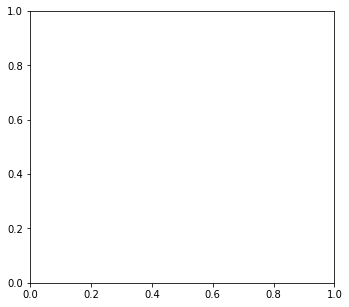

In [12]:
conv = [64, 128, 32]
nh = [50, 100, 25]
pd = [0.1, 0.2, 0.05]

run = main(conv = conv, nh = nh, pd = pd, epo = 100, batch = 10, test_size = 0.2)

np.random.seed(999)
samples = np.random.randint(1, 20, 10)
run.prediction(samples)